In [1]:
from __future__ import print_function, division
#Allows relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports from files
from src.preprocessing import *
from src.VAE_train import *
from vae_cel.vae_cel import *
from vae_cel.vae_cel_train import *
from vae_cel.DeepRC_VAE import *
from src.embedding_visualisation import * 
from src.loss_metrics import *
from src.pickling import *
from src.datasets import *

import pandas as pd 
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))
    
#Plot and stuff
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 200
sns.set_style('darkgrid')

torch.cuda.empty_cache()
# Ignore warnings)
import warnings
warnings.filterwarnings("ignore")
    
%load_ext autoreload
%autoreload 2

Using : cuda


### Reloading VAE

In [2]:
from src.torch_util import *
model = VAE_cel(latent_dim = 100, aa_dim = 25)
model = load_model(model, '../output/HyperbolicContinueTraining/LOWERBETA_DirectlyMax/BEST_VAE_tune-weighted0.5_latent100_Pad-before_Annealing-None-gamma1.0.pth.tar')
model.to('cpu');

Model succesfully loaded from ../output/HyperbolicContinueTraining/LOWERBETA_DirectlyMax/BEST_VAE_tune-weighted0.5_latent100_Pad-before_Annealing-None-gamma1.0.pth.tar:
	epoch: 74


In [3]:
vdjdb = pd.read_csv('../training_data_new/db/cdr3b_vdjdb.csv')
mcpas = pd.read_csv('../training_data_new/db/McPAS-TCR_trbvj.csv')

In [10]:
mcpas.groupby('Epitope_peptide').agg(count=(mcpas.columns[0],'count'))\
     .sort_values('count', ascending=False)\
     .head(10)

,count
Epitope_peptide,
LPRRSGAAGA,2145
GILGFVFTL,1386
GLCTLVAML,1026
SSYRRPVGI,653
SSLENFRAYV,543
NLVPMVATV,489
WEDLFCDESLSSPEPPSSSE,475
CRVLCCYVL,435
ASNENMETM,427


In [4]:
vdjdb['v'] = vdjdb['v_segm'].apply(lambda x: int(x.split('V')[1].split('-')[0]) if '-' in x else int(x.split('V')[1].split('*')[0]))
vdjdb['j'] = vdjdb['j_segm'].apply(lambda x: int(x.split('J')[1].split('-')[0]) if '-' in x else int(x.split('J')[1].split('*')[0]))
vdjdb.v-=1
vdjdb.j-=1
vdjdb = vdjdb.drop(index=(vdjdb.query('v==30').index))

In [5]:
top5_epitopes = vdjdb.groupby('antigen_epitope').agg(count=('gene','count')).sort_values('count',ascending=False).head().index
top5 = vdjdb.query('antigen_epitope in @top5_epitopes and cdr3.str.len() <= 23').reset_index()

In [6]:
top5.groupby('antigen_epitope').count()

,index,complex_id,gene,cdr3,v_segm,j_segm,species,mhc_a,mhc_b,mhc_class,antigen_gene,antigen_species,v,j
antigen_epitope,,,,,,,,,,,,,,
AVFDRKSDAK,1780,1780,1780,1780,1780,1780,1780,1780,1780,1780,1780,1780,1780,1780
ELAGIGILTV,2141,2141,2141,2141,2141,2141,2141,2141,2141,2141,2141,2141,2141,2141
GILGFVFTL,4996,4996,4996,4996,4996,4996,4996,4996,4996,4996,4996,4996,4996,4996
KLGGALQAK,13966,13966,13966,13966,13966,13966,13966,13966,13966,13966,13966,13966,13966,13966
NLVPMVATV,4859,4859,4859,4859,4859,4859,4859,4859,4859,4859,4859,4859,4859,4859


# Top5 nn embedding Classifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score
#Getting the DF features for neural net 
top5_nn = top5[['cdr3','v','j','mhc_a','mhc_class','antigen_epitope','antigen_gene']]
#top5_nn['mhc_a_main'] = top5_nn['mhc_a'].apply(lambda x : int(x.split('A*')[1].split(':',1)[0]) if ':' in x else int(x.split('A*')[1]))

top_nn_emb = get_embedding_df(model, top5_nn[['cdr3','v','j']].values, 'cpu')
top5_nn = top5_nn.merge(top_nn_emb[['z_'+str(i) for i in range(100)]], left_index = True, right_index = True).sort_values('antigen_epitope')
del top5
del top_nn_emb

embedding in latent space


batch:   0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
top5_nn.query('antigen_epitope.str.startswith("GIL")').mhc_a.unique()

array(['HLA-A*02', 'HLA-A*02:01', 'HLA-A*02:01:48'], dtype=object)

In [ ]:
top5_nn.groupby('')

class PepLSTM(nn.Module):
    """Implements the embedding&LSTM only !"""
    def __init__(self, embedding_dim, hidden_dim, n_lstm_layers = 2, p_drop = 0.15):
        super(PepLSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_lstm_layers
        self.dropout = p_drop
        self.embedding = nn.Embedding(20+1, embedding_dim, padding_idx=0)
        self.lstm= nn.LSTM(input_size = self.embedding_dim,
                           hidden_size = self.hidden_dim,
                           num_layers = self.n_layers,
                           dropout= self.dropout,
                           batch_first = True)
        
    def forward(self, x):
        # Hidden/cell state definitions
        h = torch.zeros((self.n_layers, x.size(0), self.hidden_dim))
        c = torch.zeros((self.n_layers, x.size(0), self.hidden_dim))
        # Initialization for hidden and cell states
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)
        # Embedding input
        out = self.embedding(x)
        # RNN architecture, same input as output
        # LSTM layers, lstm outputs out, (h, c)
        out, (h,c) = self.lstm(out, (h,c))
        return out 

In [20]:
top5_epitopes = vdjdb.groupby('antigen_epitope').agg(count=('gene','count')).sort_values('count',ascending=False).head().index
peptide_oh = onehot_batch(top5_epitopes, max_len = 10, weighted=1, pad= 'before')
torch.argmax(peptide_oh,dim=2)

lstm = PepLSTM(embedding_dim = 10, hidden_dim = 100, 
               n_lstm_layers = 2, p_drop = 0)
lstm(torch.argmax(peptide_oh,dim=2)).shape

torch.Size([5, 10, 100])

In [21]:
print(len(mcpas.query('Epitope_peptide == "GILGFVFTL"'))/len(mcpas.query('Epitope_peptide in @top5_epitopes')))
len(vdjdb.query('antigen_epitope.str.len()<=10')), len(mcpas.query('Epitope_peptide.str.len()<=10'))

0.7021276595744681


(42701, 11189)

In [56]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
top5_nn['epitope_label'] = enc.fit_transform(top5_nn['antigen_epitope'].values)
top5_nn['mhc_a_label'] = enc.fit_transform(top5_nn['mhc_a'].values)
top5_nn.head(3)

,cdr3,v,j,mhc_a,mhc_class,antigen_epitope,antigen_gene,mhc_a_main,z_0,z_1,...,z_93,z_94,z_95,z_96,z_97,z_98,z_99,positive_class,epitope_label,mhc_a_label
5320,CASSVSGGGYNEQFF,11,1,HLA-A*11:01,MHCI,AVFDRKSDAK,EBNA4,11,0.315767,0.053022,...,0.304175,-1.739772,1.268773,0.512199,-0.644880,0.726943,1.140417,0,0,8
5668,CASSLSGQGSGELFF,6,1,HLA-A*11:01,MHCI,AVFDRKSDAK,EBNA4,11,-0.627880,2.428225,...,-0.497607,-2.231311,-0.579145,-1.685087,-0.121275,0.850623,0.433427,0,0,8
5669,CASSPIGGEALGETQYF,13,1,HLA-A*11:01,MHCI,AVFDRKSDAK,EBNA4,11,-1.212523,-0.143641,...,-0.302143,-0.699543,-1.090501,0.029519,-0.504477,-1.369220,0.007106,0,0,8


In [50]:
class MLP(nn.Module):
    def __init__(self, n_layers, n_hidden, n_output, 
                 activation = nn.SELU(), p_drop = 0.5, dropout = True):
        
        super(MLP, self).__init__()
        if dropout == True :
            self.drop = nn.Dropout(p_drop)
        else: 
            self.drop = nn.Identity()
            
        self.input_layers = nn.Sequential(nn.Linear(100, 200),
                                          nn.BatchNorm1d(200),
                                          activation,
                                          self.drop,
                                          nn.Linear(200,150),
                                          nn.BatchNorm1d(150),
                                          activation,
                                          self.drop,
                                          nn.Linear(150,n_hidden),
                                          activation,
                                          self.drop)
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(activation)
            layers.append(self.drop) 
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(n_hidden, n_output) 
    
    def forward(self, x):
        x = self.input_layers(x)
        x = self.hidden_layers(x)
        x = self.output(x)
        #x = F.relu(x)
        #x = F.softmax(x, dim= 1) No need because CEL takes logits and has softmax built-in
        return x 

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score

def train_model(model, X_train, y_train, batch_size, criterion, optimizer):
    model.train()
    train_loss = 0
    for b in BatchSampler(RandomSampler(X_train), batch_size = batch_size,
                               drop_last = False):
                     #position = 1,
                     #leave = False):
        values = X_train[b]
        target = y_train[b]
        score = model(values)
        t_loss = criterion(score, target)
        model.zero_grad()
        t_loss.backward()
        optimizer.step()
        train_loss += t_loss.item()   
        
    train_loss /= math.ceil((len(X_train)/batch_size))
    return train_loss

def val_model(model, X_val, y_val, batch_size, criterion):
    model.eval()
    val_loss = 0
    for b in BatchSampler(RandomSampler(X_val), batch_size = batch_size,
                           drop_last = False):
        values = X_val[b]
        target = y_val[b]
        with torch.no_grad():
            score = model(values)
        v_loss = criterion(score, target)
        val_loss += v_loss.item()
        
    val_loss /= math.ceil((len(X_val)/batch_size))
    return val_loss
        
def train_clf(model, data:tuple, loss_fct = nn.CrossEntropyLoss, 
              optimizer_module = torch.optim.AdamW,
              lr=5e-5, wd=1e-4, nb_epochs=1000, 
              batch_size=2**9, loss_weight = None, device='cuda'):
    
    X_train, X_val, y_train, y_val = data
    
    #X_train.to(device)
    #X_val.to(device)
    #y_train.to(device)
    #y_val.to(device)
    #
    #model.to(device)
    
    if loss_weight is not None:
        weights = loss_weight
    else:
        tmp = torch.cat((y_train,y_val), dim=0).max().item()+1
        weights = torch.ones((tmp,))
    #weights = 1/(top5_nn.groupby('antigen_epitope').agg(count=('cdr3','count')).values/len(top5_nn))
    criterion = loss_fct(weight=torch.tensor(weights,device='cuda').float())
    optimizer = optimizer_module(model.parameters(), lr = lr, weight_decay= wd)
    
    train_losses = []
    val_losses = []
    rocs = []
    accs = []
    broken = False
    for e in tqdm(range(nb_epochs),
                 position = 0, leave = False):
        train_loss = train_model(model, X_train, y_train, batch_size, criterion, optimizer)
        val_loss = val_model(model, X_val, y_val, batch_size, criterion)
        #train
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        mlp.eval()
        if val_loss > 1 and e > 100:
            broken = True
            break
        if e%50 == 0 or e==nb_epochs-1:
            y_true = y_val.cpu().numpy()
            with torch.no_grad():
                score = F.softmax(model(X_val), dim =1 ).cpu()
                preds = torch.argmax(score,dim=1).numpy()
            if y_val.max() >1:
                multi = 'ovo'
                average = 'macro'
            else:
                multi = 'ovr'
                average = 'macro'
                score = score[:,1]
            roc_auc = roc_auc_score(y_true, score.numpy(), average = average,
                                    multi_class = multi)
            rocs.append(roc_auc)
            acc = accuracy_score(y_true, preds)
            accs.append(acc)
            print(f'Epoch:{e};\tTrain: {train_loss:.3e}\tVal: {val_loss:.3e}'\
                  f'\n\t\tROC AUC :{roc_auc:.3f}, \taccuracy: {acc:.3f}')
    
    losses = {'train': train_losses,
              'val' : val_losses,
              'roc': rocs,
              'acc': accs}
    cs = ['b-', 'r-']#, 'g-.', 'm-.']
    
    for k, c in zip(losses.keys(), cs):
        plt.plot(losses[k], color = c[0], ls = c[1], label = k)
    
    if broken == False:
        x = np.arange(start=0,stop=nb_epochs,step=50)
        x = np.append(x, nb_epochs-1)
        plt.plot(x, rocs, color = 'g', ls = '-.', marker = 'o', markersize = 5, label = 'ROC AUC')
        plt.plot(x, accs, color = 'm', ls = '-.', marker = 'x', markersize = 5, label = 'Accuracy')
        
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    return losses

### Multi(weighted) class

In [70]:
X = torch.tensor(top5_nn[['z_'+str(i) for i in range(100)]].values, device = 'cuda')
y = torch.tensor(top5_nn['epitope_label'].values, device = 'cuda').long()
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.7, shuffle=True)

mlp = MLP(10, 300, activation = nn.ReLU(), n_output = len(y.unique()))
mlp.to(device);

nb_epochs = 1000
batch_size = 2**9
#total len = 27700
weights = 1/(top5_nn.groupby('antigen_epitope').agg(count=('cdr3','count')).values/len(top5_nn))

train_clf(model = mlp, data = (X_train,X_val,y_train, y_val), lr = 3e-5, wd = 1e-4,
          nb_epochs = nb_epochs, batch_size = batch_size, loss_weight = weights)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:0;	Train: 1.611e+00	Val: 1.611e+00
		ROC AUC :5.015e-01, 	accuracy: 1.802e-01


KeyboardInterrupt: 

### OvR 

In [291]:
top5_nn.antigen_epitope.str.len().describe()

count    27742.000000
mean         9.141338
std          0.348376
min          9.000000
25%          9.000000
50%          9.000000
75%          9.000000
max         10.000000
Name: antigen_epitope, dtype: float64

In [10]:
top5_nn.groupby('antigen_epitope').count()

,cdr3,v,j,mhc_a,mhc_class,antigen_gene,mhc_a_main,z_0,z_1,z_2,...,z_90,z_91,z_92,z_93,z_94,z_95,z_96,z_97,z_98,z_99
antigen_epitope,,,,,,,,,,,,,,,,,,,,,
AVFDRKSDAK,1780,1780,1780,1780,1780,1780,1780,1780,1780,1780,...,1780,1780,1780,1780,1780,1780,1780,1780,1780,1780
ELAGIGILTV,2141,2141,2141,2141,2141,2141,2141,2141,2141,2141,...,2141,2141,2141,2141,2141,2141,2141,2141,2141,2141
GILGFVFTL,4996,4996,4996,4996,4996,4996,4996,4996,4996,4996,...,4996,4996,4996,4996,4996,4996,4996,4996,4996,4996
KLGGALQAK,13966,13966,13966,13966,13966,13966,13966,13966,13966,13966,...,13966,13966,13966,13966,13966,13966,13966,13966,13966,13966
NLVPMVATV,4859,4859,4859,4859,4859,4859,4859,4859,4859,4859,...,4859,4859,4859,4859,4859,4859,4859,4859,4859,4859


##### Doing for GILGFVFTL

In [118]:
def ovr_xy_split_class(df, col = 'antigen_epitope', pos_label = 'GILGFVFTL', train_size=.7):
    top5_nn['positive_class'] = top5_nn[col].apply(lambda x: 1 if x == pos_label else 0)
    X = torch.tensor(top5_nn[['z_'+str(i) for i in range(100)]].values, device = 'cuda')
    y = torch.tensor(top5_nn['positive_class'].values, device = 'cuda').long()
    X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = train_size, shuffle=True)
    return X_train, X_val, y_train, y_val

def get_min(array, x_epochs):
    index = np.argmin(array)
    value = array[index]
    epoch = x_epochs[index]
    return epoch, value

def get_max(array, x_epochs):
    index = np.argmax(array)
    value = array[index]
    epoch = x_epochs[index]
    return epoch, value

In [145]:
class MLP(nn.Module):
    
    def __init__(self, n_layers, n_hidden, n_output, 
                 activation = nn.SELU(), p_drop = 0.5)# dropout = True):
        
        super(MLP, self).__init__()
        if p_drop >0 :
            self.drop = nn.Dropout(p_drop)
        else: 
            self.drop = nn.Identity()
            
        self.input_layers = nn.Sequential(nn.Linear(100, 200),
                                          nn.BatchNorm1d(200),
                                          activation,
                                          self.drop,
                                          nn.Linear(200,150),
                                          nn.BatchNorm1d(150),
                                          activation,
                                          self.drop,
                                          nn.Linear(150,n_hidden),
                                          activation,
                                          self.drop)
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(activation)
            layers.append(self.drop)
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(n_hidden, n_output)
        
    
    def forward(self, x):
        x = self.input_layers(x)
        x = self.hidden_layers(x)
        x = self.output(x)
        x = F.relu(x)
        #x = F.softmax(x, dim= 1) No need because CEL takes logits and has softmax built-in
        
        return x 

In [93]:
top5_nn.antigen_epitope.unique()

array(['AVFDRKSDAK', 'ELAGIGILTV', 'GILGFVFTL', 'KLGGALQAK', 'NLVPMVATV'],
      dtype=object)

FOR CURRENT EPITOPE : AVFDRKSDAK, % of positive class = 6.42%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 6.984e-01	Val: 5.142e-01
		ROC AUC :0.500, 	accuracy: 0.936
Epoch:50;	Train: 2.638e-01	Val: 2.515e-01
		ROC AUC :0.507, 	accuracy: 0.938
Epoch:100;	Train: 2.539e-01	Val: 2.331e-01
		ROC AUC :0.513, 	accuracy: 0.938
Epoch:150;	Train: 2.465e-01	Val: 2.464e-01
		ROC AUC :0.508, 	accuracy: 0.938
Epoch:200;	Train: 2.425e-01	Val: 2.338e-01
		ROC AUC :0.509, 	accuracy: 0.938
Epoch:250;	Train: 2.435e-01	Val: 2.322e-01
		ROC AUC :0.505, 	accuracy: 0.938
Epoch:300;	Train: 2.433e-01	Val: 2.335e-01
		ROC AUC :0.504, 	accuracy: 0.938
Epoch:350;	Train: 2.456e-01	Val: 2.310e-01
		ROC AUC :0.504, 	accuracy: 0.938
Epoch:400;	Train: 2.405e-01	Val: 2.426e-01
		ROC AUC :0.504, 	accuracy: 0.938
Epoch:450;	Train: 2.456e-01	Val: 2.330e-01
		ROC AUC :0.501, 	accuracy: 0.938
Epoch:500;	Train: 2.438e-01	Val: 2.499e-01
		ROC AUC :0.498, 	accuracy: 0.938
Epoch:550;	Train: 2.378e-01	Val: 2.646e-01
		ROC AUC :0.498, 	accuracy: 0.938
Epoch:600;	Train: 2.324e-01	Val: 2.214e-01
		ROC AUC :0.501, 	accur

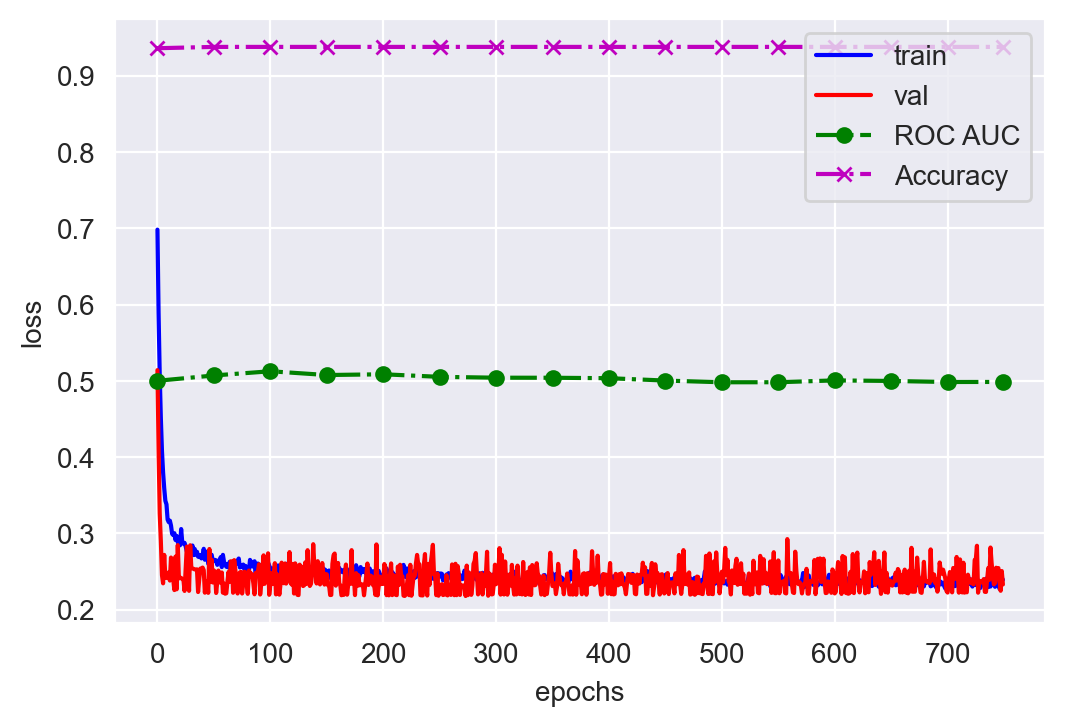

FOR CURRENT EPITOPE : ELAGIGILTV, % of positive class = 7.72%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 6.738e-01	Val: 4.900e-01
		ROC AUC :0.488, 	accuracy: 0.923
Epoch:50;	Train: 2.937e-01	Val: 2.822e-01
		ROC AUC :0.562, 	accuracy: 0.923
Epoch:100;	Train: 2.801e-01	Val: 2.692e-01
		ROC AUC :0.569, 	accuracy: 0.923
Epoch:150;	Train: 2.842e-01	Val: 2.895e-01
		ROC AUC :0.566, 	accuracy: 0.923
Epoch:200;	Train: 2.680e-01	Val: 2.646e-01
		ROC AUC :0.567, 	accuracy: 0.923
Epoch:250;	Train: 2.798e-01	Val: 2.779e-01
		ROC AUC :0.568, 	accuracy: 0.923
Epoch:300;	Train: 2.833e-01	Val: 2.630e-01
		ROC AUC :0.565, 	accuracy: 0.923
Epoch:350;	Train: 2.702e-01	Val: 2.933e-01
		ROC AUC :0.567, 	accuracy: 0.923
Epoch:400;	Train: 2.673e-01	Val: 2.744e-01
		ROC AUC :0.568, 	accuracy: 0.923
Epoch:450;	Train: 2.635e-01	Val: 2.943e-01
		ROC AUC :0.563, 	accuracy: 0.923
Epoch:500;	Train: 2.627e-01	Val: 2.653e-01
		ROC AUC :0.566, 	accuracy: 0.923
Epoch:550;	Train: 2.644e-01	Val: 3.030e-01
		ROC AUC :0.563, 	accuracy: 0.923
Epoch:600;	Train: 2.680e-01	Val: 2.904e-01
		ROC AUC :0.561, 	accur

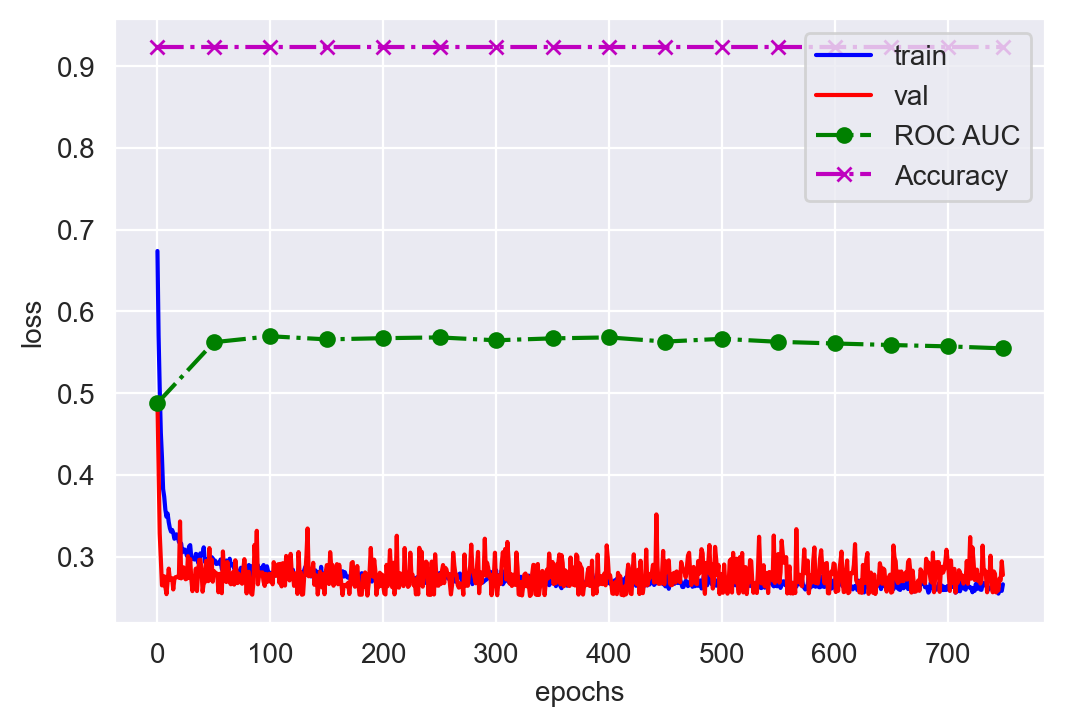

FOR CURRENT EPITOPE : GILGFVFTL, % of positive class = 18.01%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 6.945e-01	Val: 5.812e-01
		ROC AUC :0.497, 	accuracy: 0.821
Epoch:50;	Train: 4.910e-01	Val: 4.744e-01
		ROC AUC :0.575, 	accuracy: 0.821
Epoch:100;	Train: 4.802e-01	Val: 4.758e-01
		ROC AUC :0.581, 	accuracy: 0.821
Epoch:150;	Train: 4.760e-01	Val: 4.747e-01
		ROC AUC :0.582, 	accuracy: 0.821
Epoch:200;	Train: 4.717e-01	Val: 4.599e-01
		ROC AUC :0.582, 	accuracy: 0.821
Epoch:250;	Train: 4.684e-01	Val: 4.815e-01
		ROC AUC :0.583, 	accuracy: 0.821
Epoch:300;	Train: 4.622e-01	Val: 4.880e-01
		ROC AUC :0.581, 	accuracy: 0.821
Epoch:350;	Train: 4.623e-01	Val: 4.565e-01
		ROC AUC :0.582, 	accuracy: 0.821
Epoch:400;	Train: 4.614e-01	Val: 4.591e-01
		ROC AUC :0.582, 	accuracy: 0.821
Epoch:450;	Train: 4.642e-01	Val: 4.571e-01
		ROC AUC :0.581, 	accuracy: 0.821
Epoch:500;	Train: 4.627e-01	Val: 4.500e-01
		ROC AUC :0.582, 	accuracy: 0.821
Epoch:550;	Train: 4.624e-01	Val: 4.509e-01
		ROC AUC :0.582, 	accuracy: 0.821
Epoch:600;	Train: 4.579e-01	Val: 4.631e-01
		ROC AUC :0.584, 	accur

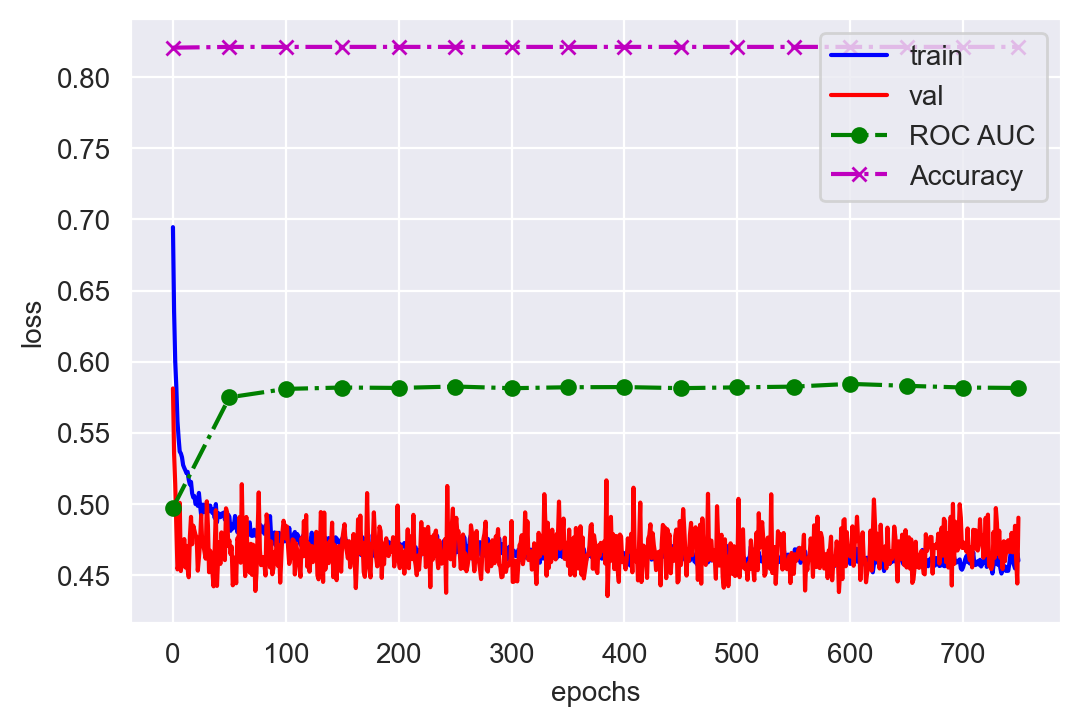

FOR CURRENT EPITOPE : KLGGALQAK, % of positive class = 50.34%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 7.575e-01	Val: 6.957e-01
		ROC AUC :0.498, 	accuracy: 0.499
Epoch:50;	Train: 7.023e-01	Val: 6.913e-01
		ROC AUC :0.520, 	accuracy: 0.515
Epoch:100;	Train: 6.963e-01	Val: 6.936e-01
		ROC AUC :0.521, 	accuracy: 0.514
Epoch:150;	Train: 6.922e-01	Val: 6.923e-01
		ROC AUC :0.521, 	accuracy: 0.518
Epoch:200;	Train: 6.906e-01	Val: 6.960e-01
		ROC AUC :0.520, 	accuracy: 0.514
Epoch:250;	Train: 6.902e-01	Val: 6.937e-01
		ROC AUC :0.519, 	accuracy: 0.513
Epoch:300;	Train: 6.906e-01	Val: 6.979e-01
		ROC AUC :0.517, 	accuracy: 0.515
Epoch:350;	Train: 6.885e-01	Val: 6.987e-01
		ROC AUC :0.518, 	accuracy: 0.516
Epoch:400;	Train: 6.898e-01	Val: 6.945e-01
		ROC AUC :0.518, 	accuracy: 0.515
Epoch:450;	Train: 6.898e-01	Val: 6.920e-01
		ROC AUC :0.518, 	accuracy: 0.514
Epoch:500;	Train: 6.871e-01	Val: 6.942e-01
		ROC AUC :0.518, 	accuracy: 0.516
Epoch:550;	Train: 6.883e-01	Val: 6.965e-01
		ROC AUC :0.517, 	accuracy: 0.514
Epoch:600;	Train: 6.879e-01	Val: 6.957e-01
		ROC AUC :0.518, 	accur

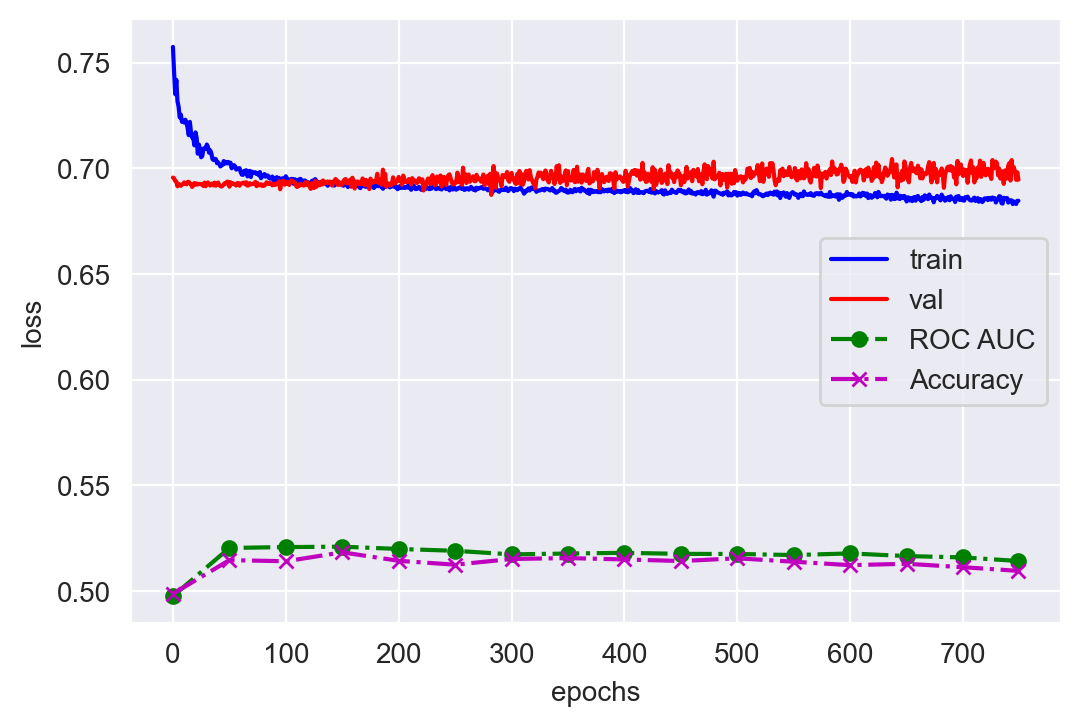

FOR CURRENT EPITOPE : NLVPMVATV, % of positive class = 17.51%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 6.984e-01	Val: 5.658e-01
		ROC AUC :0.491, 	accuracy: 0.826
Epoch:50;	Train: 4.823e-01	Val: 4.732e-01
		ROC AUC :0.504, 	accuracy: 0.826
Epoch:100;	Train: 4.746e-01	Val: 4.744e-01
		ROC AUC :0.501, 	accuracy: 0.826
Epoch:150;	Train: 4.626e-01	Val: 4.572e-01
		ROC AUC :0.499, 	accuracy: 0.826
Epoch:200;	Train: 4.649e-01	Val: 4.760e-01
		ROC AUC :0.498, 	accuracy: 0.826
Epoch:250;	Train: 4.646e-01	Val: 4.817e-01
		ROC AUC :0.498, 	accuracy: 0.826
Epoch:300;	Train: 4.612e-01	Val: 4.712e-01
		ROC AUC :0.499, 	accuracy: 0.826
Epoch:350;	Train: 4.681e-01	Val: 4.545e-01
		ROC AUC :0.497, 	accuracy: 0.826
Epoch:400;	Train: 4.661e-01	Val: 4.693e-01
		ROC AUC :0.497, 	accuracy: 0.826
Epoch:450;	Train: 4.602e-01	Val: 4.726e-01
		ROC AUC :0.497, 	accuracy: 0.826
Epoch:500;	Train: 4.578e-01	Val: 4.601e-01
		ROC AUC :0.496, 	accuracy: 0.826
Epoch:550;	Train: 4.620e-01	Val: 4.790e-01
		ROC AUC :0.495, 	accuracy: 0.826
Epoch:600;	Train: 4.575e-01	Val: 4.802e-01
		ROC AUC :0.496, 	accur

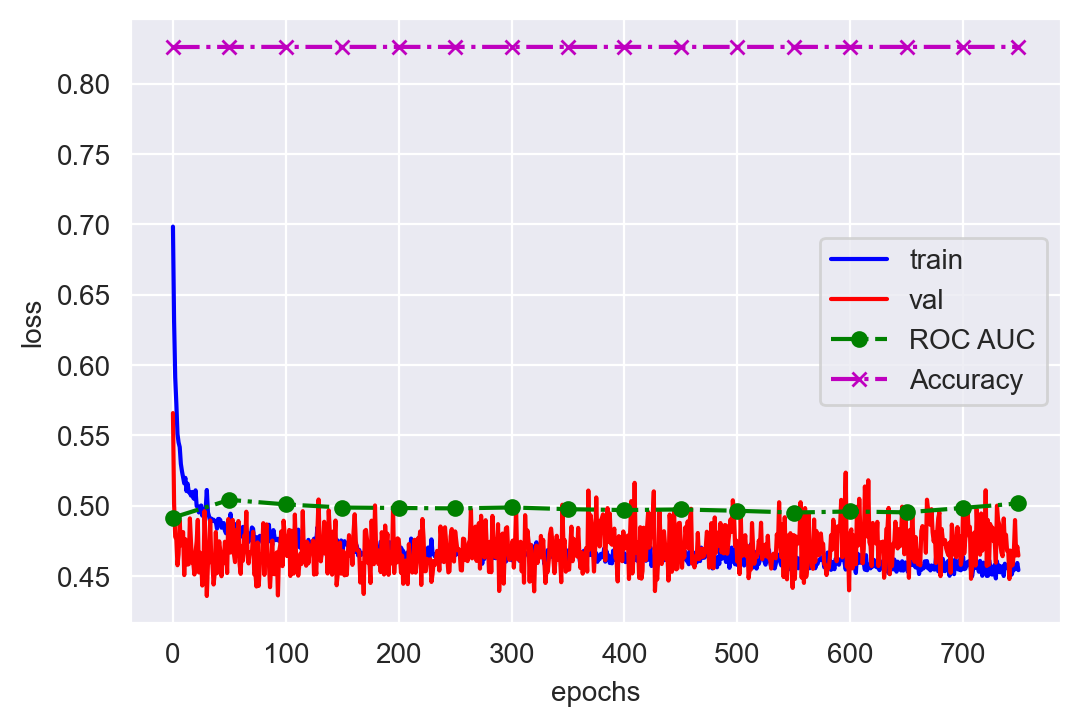

In [135]:
epi_ls = {}
for epi in tqdm(top5_nn.antigen_epitope.unique()):
    X_train, X_val, y_train, y_val = ovr_xy_split_class(top5_nn, epi, train_size = .667)
    cb = len(top5_nn.query('antigen_epitope==@epi'))/len(top5_nn)
    print(f'FOR CURRENT EPITOPE : {epi}, % of positive class = {cb:.2%}')
    
    mlp = MLP(2,300 , n_output = 2)
    mlp.to(device);
    losses = train_clf(model = mlp, data = (X_train,X_val,y_train, y_val), lr = 6.67e-5, wd = 1e-2,
              nb_epochs = 750, batch_size = 2**10, loss_weight = None)
    epi_ls[epi] = losses

  0%|          | 0/5 [00:00<?, ?it/s]

FOR CURRENT EPITOPE : AVFDRKSDAK, % of positive class = 6.42%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 7.282e-01	Val: 6.754e-01
		ROC AUC :0.506, 	accuracy: 0.704
Epoch:50;	Train: 2.748e-01	Val: 2.657e-01
		ROC AUC :0.508, 	accuracy: 0.935
Epoch:100;	Train: 2.500e-01	Val: 2.455e-01
		ROC AUC :0.514, 	accuracy: 0.935
Epoch:150;	Train: 2.488e-01	Val: 2.414e-01
		ROC AUC :0.520, 	accuracy: 0.935
Epoch:200;	Train: 2.470e-01	Val: 2.269e-01
		ROC AUC :0.522, 	accuracy: 0.935
Epoch:250;	Train: 2.403e-01	Val: 2.517e-01
		ROC AUC :0.525, 	accuracy: 0.935
Epoch:300;	Train: 2.458e-01	Val: 2.249e-01
		ROC AUC :0.523, 	accuracy: 0.935
Epoch:350;	Train: 2.401e-01	Val: 2.508e-01
		ROC AUC :0.524, 	accuracy: 0.935
Epoch:400;	Train: 2.367e-01	Val: 2.241e-01
		ROC AUC :0.529, 	accuracy: 0.935
Epoch:450;	Train: 2.404e-01	Val: 2.366e-01
		ROC AUC :0.529, 	accuracy: 0.935
Epoch:500;	Train: 2.472e-01	Val: 2.364e-01
		ROC AUC :0.528, 	accuracy: 0.935
Epoch:550;	Train: 2.390e-01	Val: 2.488e-01
		ROC AUC :0.528, 	accuracy: 0.935
Epoch:600;	Train: 2.420e-01	Val: 2.602e-01
		ROC AUC :0.529, 	accur

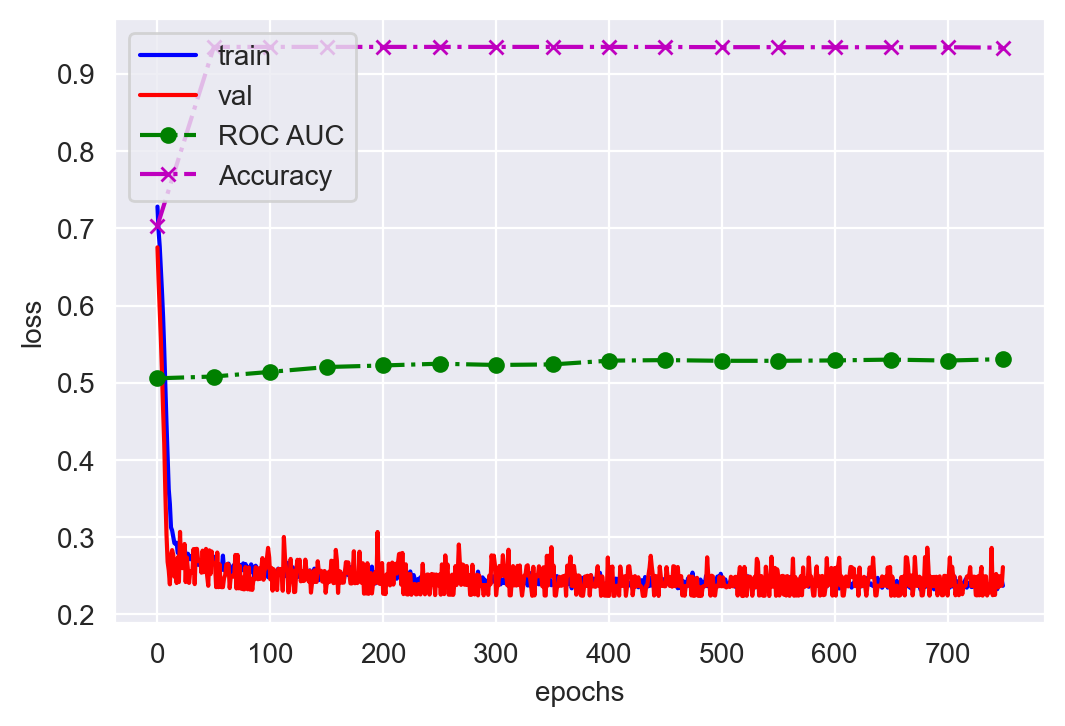

FOR CURRENT EPITOPE : ELAGIGILTV, % of positive class = 7.72%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 6.794e-01	Val: 6.917e-01
		ROC AUC :0.505, 	accuracy: 0.921
Epoch:50;	Train: 2.872e-01	Val: 3.537e-01
		ROC AUC :0.568, 	accuracy: 0.921
Epoch:100;	Train: 2.795e-01	Val: 2.913e-01
		ROC AUC :0.568, 	accuracy: 0.921
Epoch:150;	Train: 2.796e-01	Val: 3.121e-01
		ROC AUC :0.568, 	accuracy: 0.921
Epoch:200;	Train: 2.760e-01	Val: 2.955e-01
		ROC AUC :0.566, 	accuracy: 0.921
Epoch:250;	Train: 2.709e-01	Val: 2.586e-01
		ROC AUC :0.564, 	accuracy: 0.921
Epoch:300;	Train: 2.797e-01	Val: 2.825e-01
		ROC AUC :0.563, 	accuracy: 0.921
Epoch:350;	Train: 2.723e-01	Val: 2.948e-01
		ROC AUC :0.563, 	accuracy: 0.921
Epoch:400;	Train: 2.727e-01	Val: 3.115e-01
		ROC AUC :0.559, 	accuracy: 0.921
Epoch:450;	Train: 2.764e-01	Val: 2.938e-01
		ROC AUC :0.556, 	accuracy: 0.921
Epoch:500;	Train: 2.668e-01	Val: 2.590e-01
		ROC AUC :0.558, 	accuracy: 0.921
Epoch:550;	Train: 2.728e-01	Val: 2.928e-01
		ROC AUC :0.560, 	accuracy: 0.921
Epoch:600;	Train: 2.672e-01	Val: 2.938e-01
		ROC AUC :0.558, 	accur

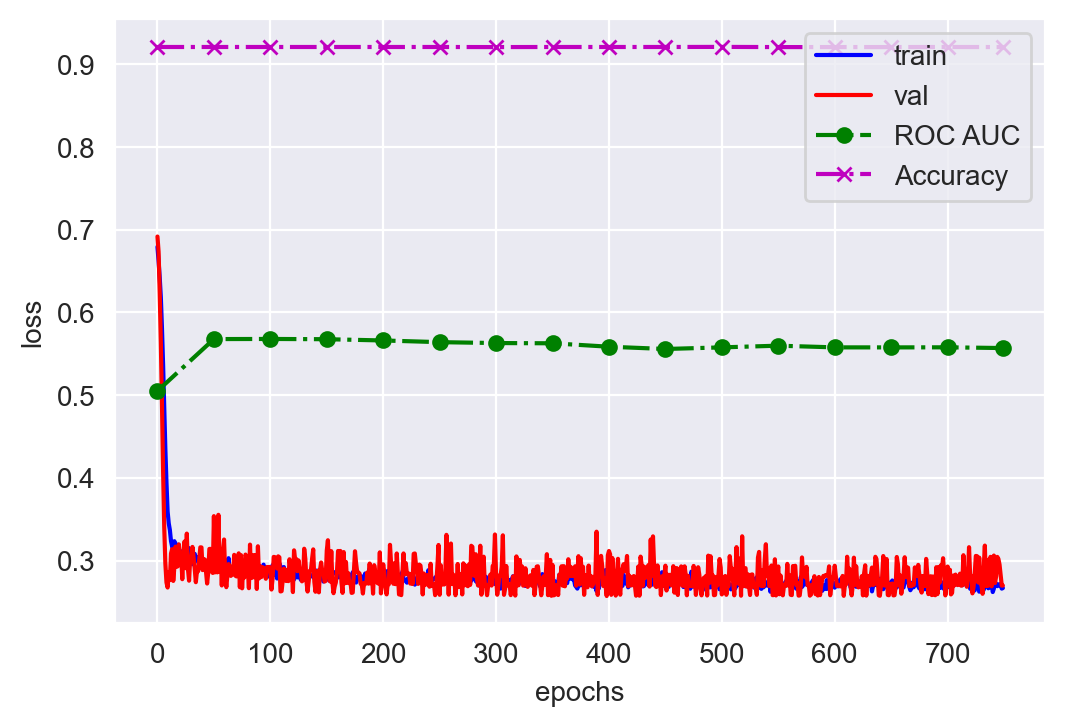

FOR CURRENT EPITOPE : GILGFVFTL, % of positive class = 18.01%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 7.065e-01	Val: 6.774e-01
		ROC AUC :0.503, 	accuracy: 0.767
Epoch:50;	Train: 4.849e-01	Val: 4.771e-01
		ROC AUC :0.570, 	accuracy: 0.819
Epoch:100;	Train: 4.842e-01	Val: 4.488e-01
		ROC AUC :0.578, 	accuracy: 0.819
Epoch:150;	Train: 4.695e-01	Val: 4.579e-01
		ROC AUC :0.579, 	accuracy: 0.819
Epoch:200;	Train: 4.750e-01	Val: 4.650e-01
		ROC AUC :0.580, 	accuracy: 0.819
Epoch:250;	Train: 4.714e-01	Val: 4.538e-01
		ROC AUC :0.580, 	accuracy: 0.819
Epoch:300;	Train: 4.680e-01	Val: 4.680e-01
		ROC AUC :0.580, 	accuracy: 0.819
Epoch:350;	Train: 4.694e-01	Val: 4.426e-01
		ROC AUC :0.580, 	accuracy: 0.819
Epoch:400;	Train: 4.695e-01	Val: 4.943e-01
		ROC AUC :0.580, 	accuracy: 0.819
Epoch:450;	Train: 4.662e-01	Val: 4.906e-01
		ROC AUC :0.580, 	accuracy: 0.819
Epoch:500;	Train: 4.669e-01	Val: 4.684e-01
		ROC AUC :0.579, 	accuracy: 0.819
Epoch:550;	Train: 4.650e-01	Val: 4.707e-01
		ROC AUC :0.579, 	accuracy: 0.819
Epoch:600;	Train: 4.666e-01	Val: 4.659e-01
		ROC AUC :0.579, 	accur

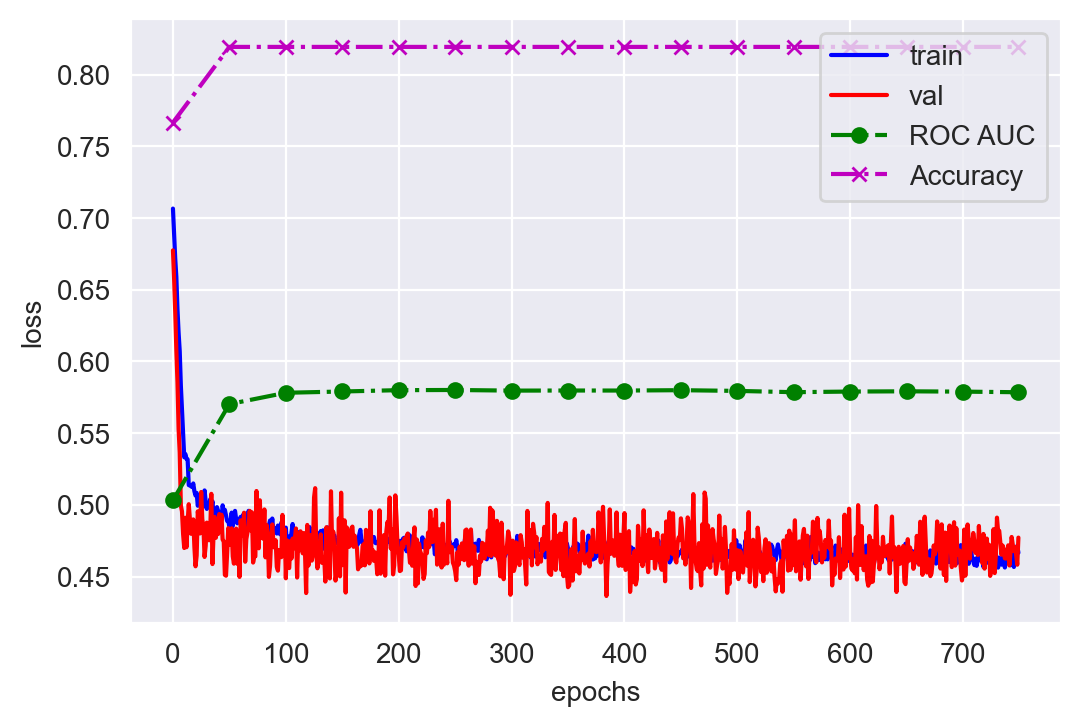

FOR CURRENT EPITOPE : KLGGALQAK, % of positive class = 50.34%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 7.026e-01	Val: 6.935e-01
		ROC AUC :0.497, 	accuracy: 0.496
Epoch:50;	Train: 6.940e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:100;	Train: 6.934e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:150;	Train: 6.933e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:200;	Train: 6.935e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:250;	Train: 6.932e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:300;	Train: 6.933e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:350;	Train: 6.931e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:400;	Train: 6.931e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:450;	Train: 6.931e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:500;	Train: 6.930e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:550;	Train: 6.930e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accuracy: 0.496
Epoch:600;	Train: 6.931e-01	Val: 6.931e-01
		ROC AUC :0.500, 	accur

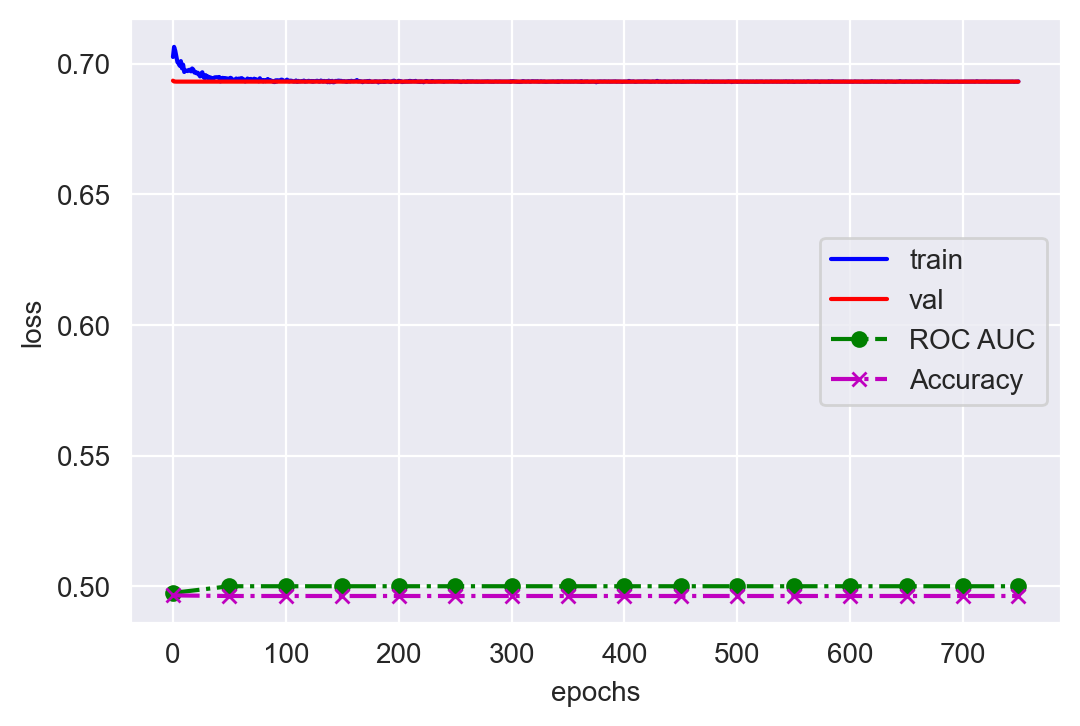

FOR CURRENT EPITOPE : NLVPMVATV, % of positive class = 17.51%


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:0;	Train: 6.824e-01	Val: 6.858e-01
		ROC AUC :0.491, 	accuracy: 0.820
Epoch:50;	Train: 4.898e-01	Val: 4.995e-01
		ROC AUC :0.494, 	accuracy: 0.820
Epoch:100;	Train: 4.767e-01	Val: 4.933e-01
		ROC AUC :0.495, 	accuracy: 0.820
Epoch:150;	Train: 4.687e-01	Val: 4.857e-01
		ROC AUC :0.496, 	accuracy: 0.820
Epoch:200;	Train: 4.746e-01	Val: 4.758e-01
		ROC AUC :0.498, 	accuracy: 0.820
Epoch:250;	Train: 4.726e-01	Val: 4.807e-01
		ROC AUC :0.499, 	accuracy: 0.820
Epoch:300;	Train: 4.660e-01	Val: 5.196e-01
		ROC AUC :0.500, 	accuracy: 0.820
Epoch:350;	Train: 4.570e-01	Val: 4.816e-01
		ROC AUC :0.502, 	accuracy: 0.820
Epoch:400;	Train: 4.625e-01	Val: 4.801e-01
		ROC AUC :0.502, 	accuracy: 0.820
Epoch:450;	Train: 4.638e-01	Val: 4.887e-01
		ROC AUC :0.502, 	accuracy: 0.820
Epoch:500;	Train: 4.593e-01	Val: 4.735e-01
		ROC AUC :0.502, 	accuracy: 0.820
Epoch:550;	Train: 4.649e-01	Val: 4.650e-01
		ROC AUC :0.503, 	accuracy: 0.820
Epoch:600;	Train: 4.627e-01	Val: 5.031e-01
		ROC AUC :0.502, 	accur

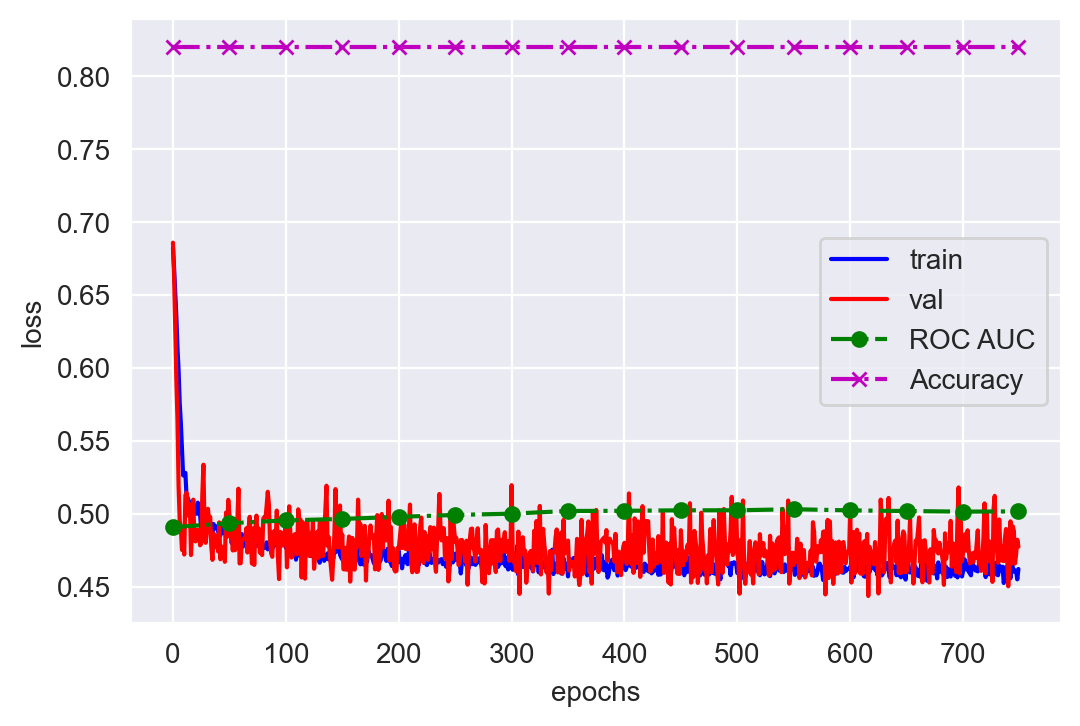

In [146]:
torch.manual_seed(20)
epi_ls = {}
for epi in tqdm(top5_nn.antigen_epitope.unique()):
    X_train, X_val, y_train, y_val = ovr_xy_split_class(top5_nn, epi, train_size = .667)
    cb = len(top5_nn.query('antigen_epitope==@epi'))/len(top5_nn)
    print(f'FOR CURRENT EPITOPE : {epi}, % of positive class = {cb:.2%}')
    
    mlp = MLP(4, 50 , n_output = 2)# nobatchnorm, but with ReLU
    mlp.to(device);
    
    losses = train_clf(model = mlp, data = (X_train,X_val,y_train, y_val), lr = 6.67e-5, wd = 1e-2,
                  nb_epochs = 750, batch_size = 2**10, loss_weight = None)
    epi_ls[epi] = losses

#### gridsearch for MLP1

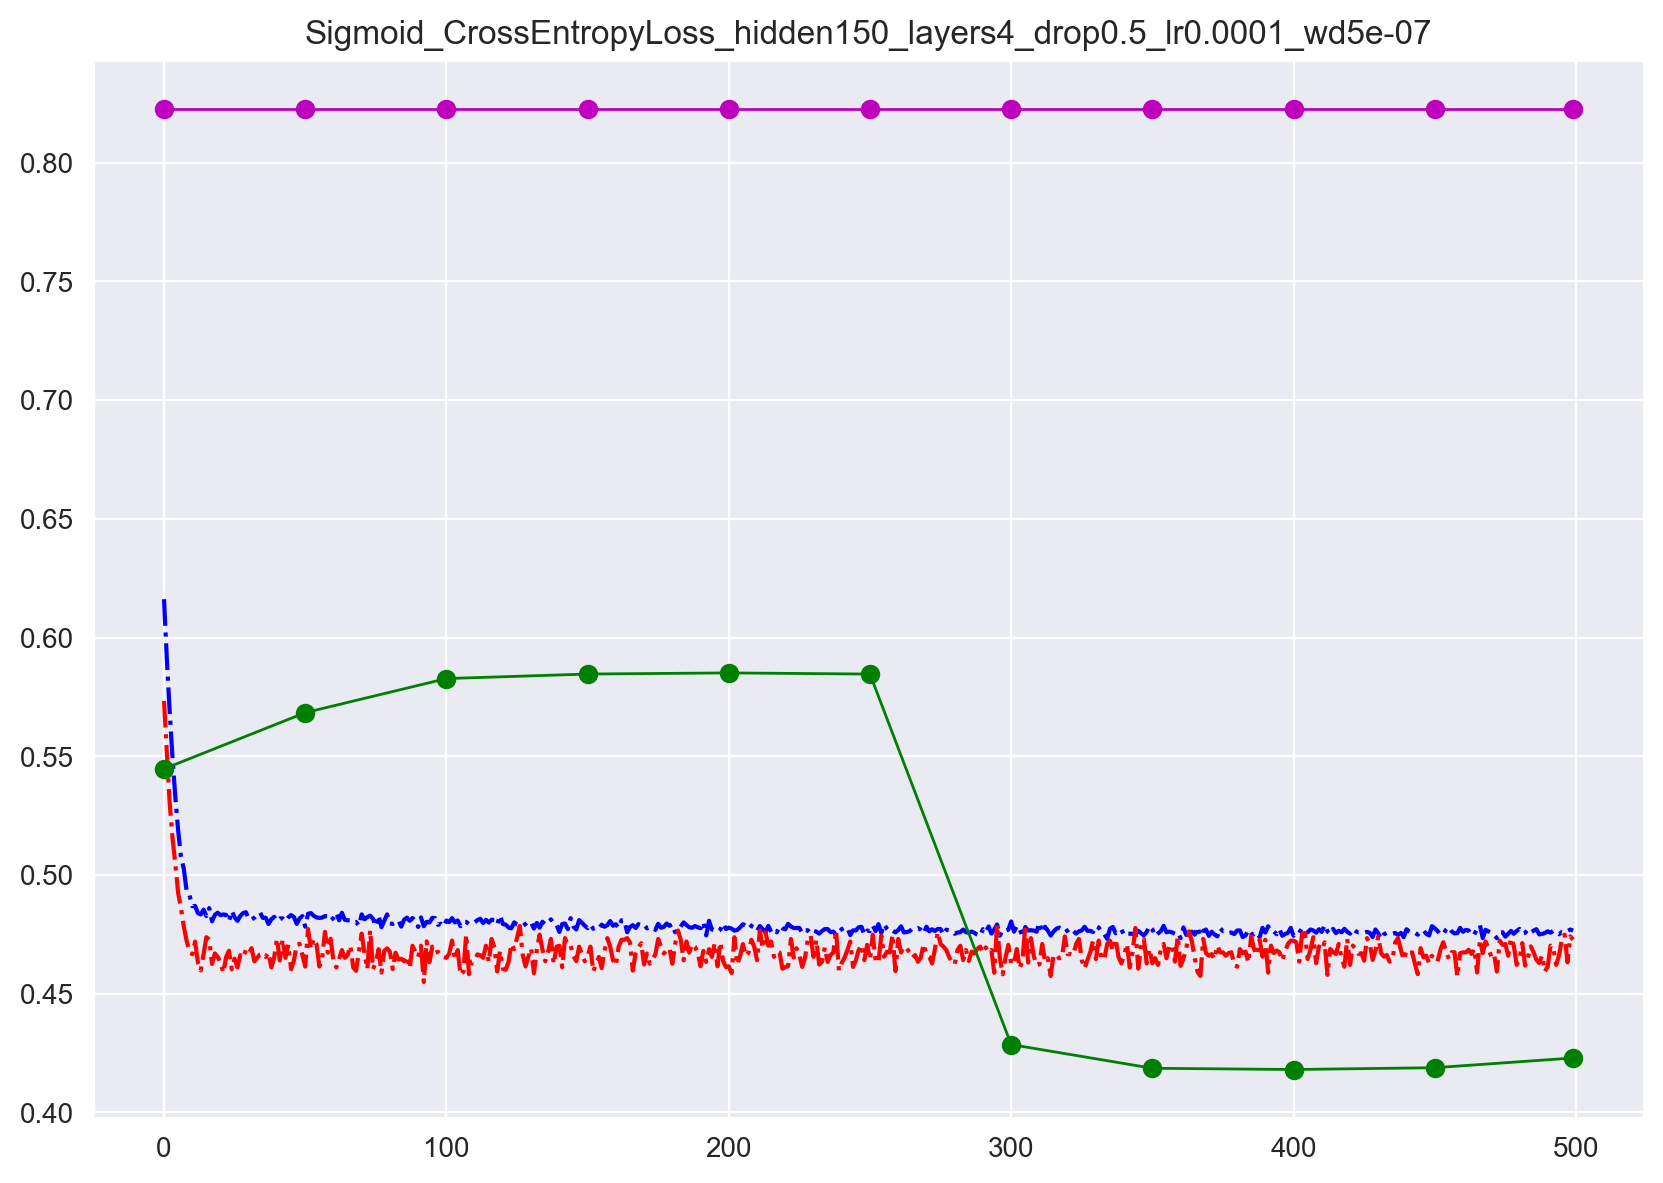

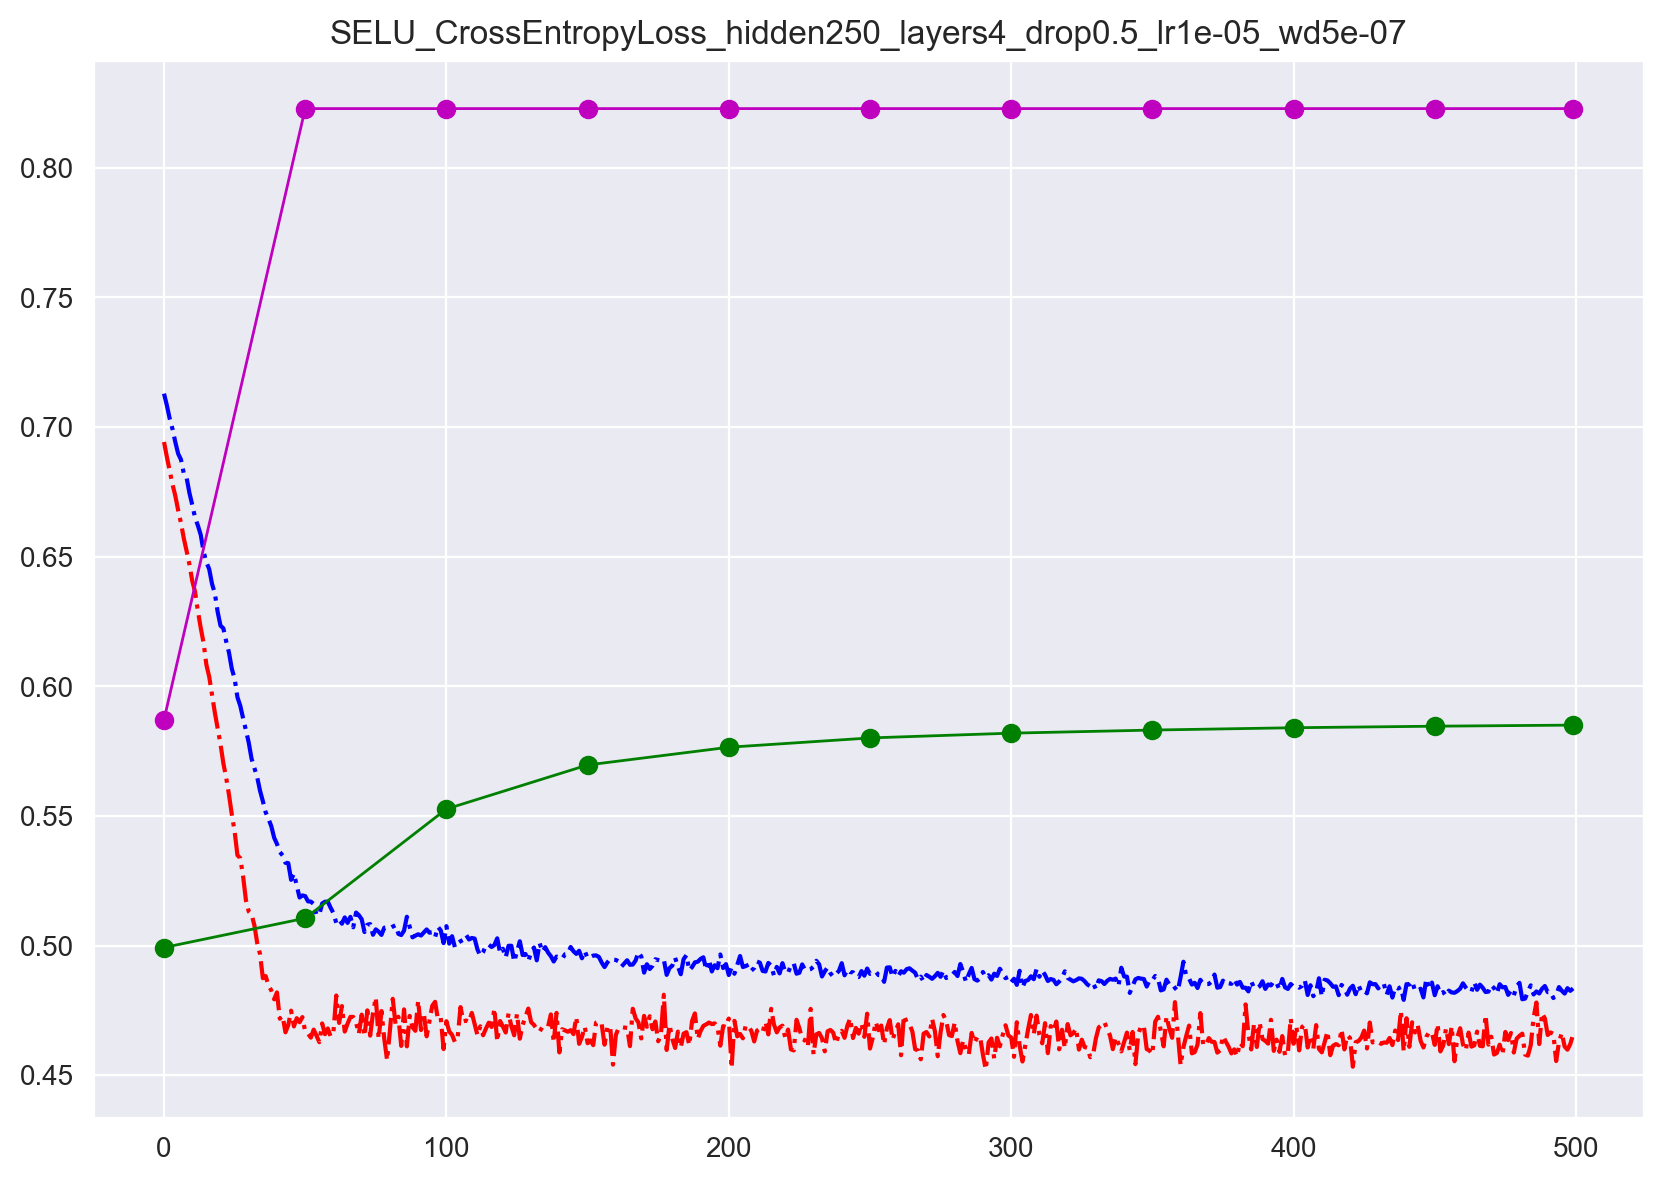

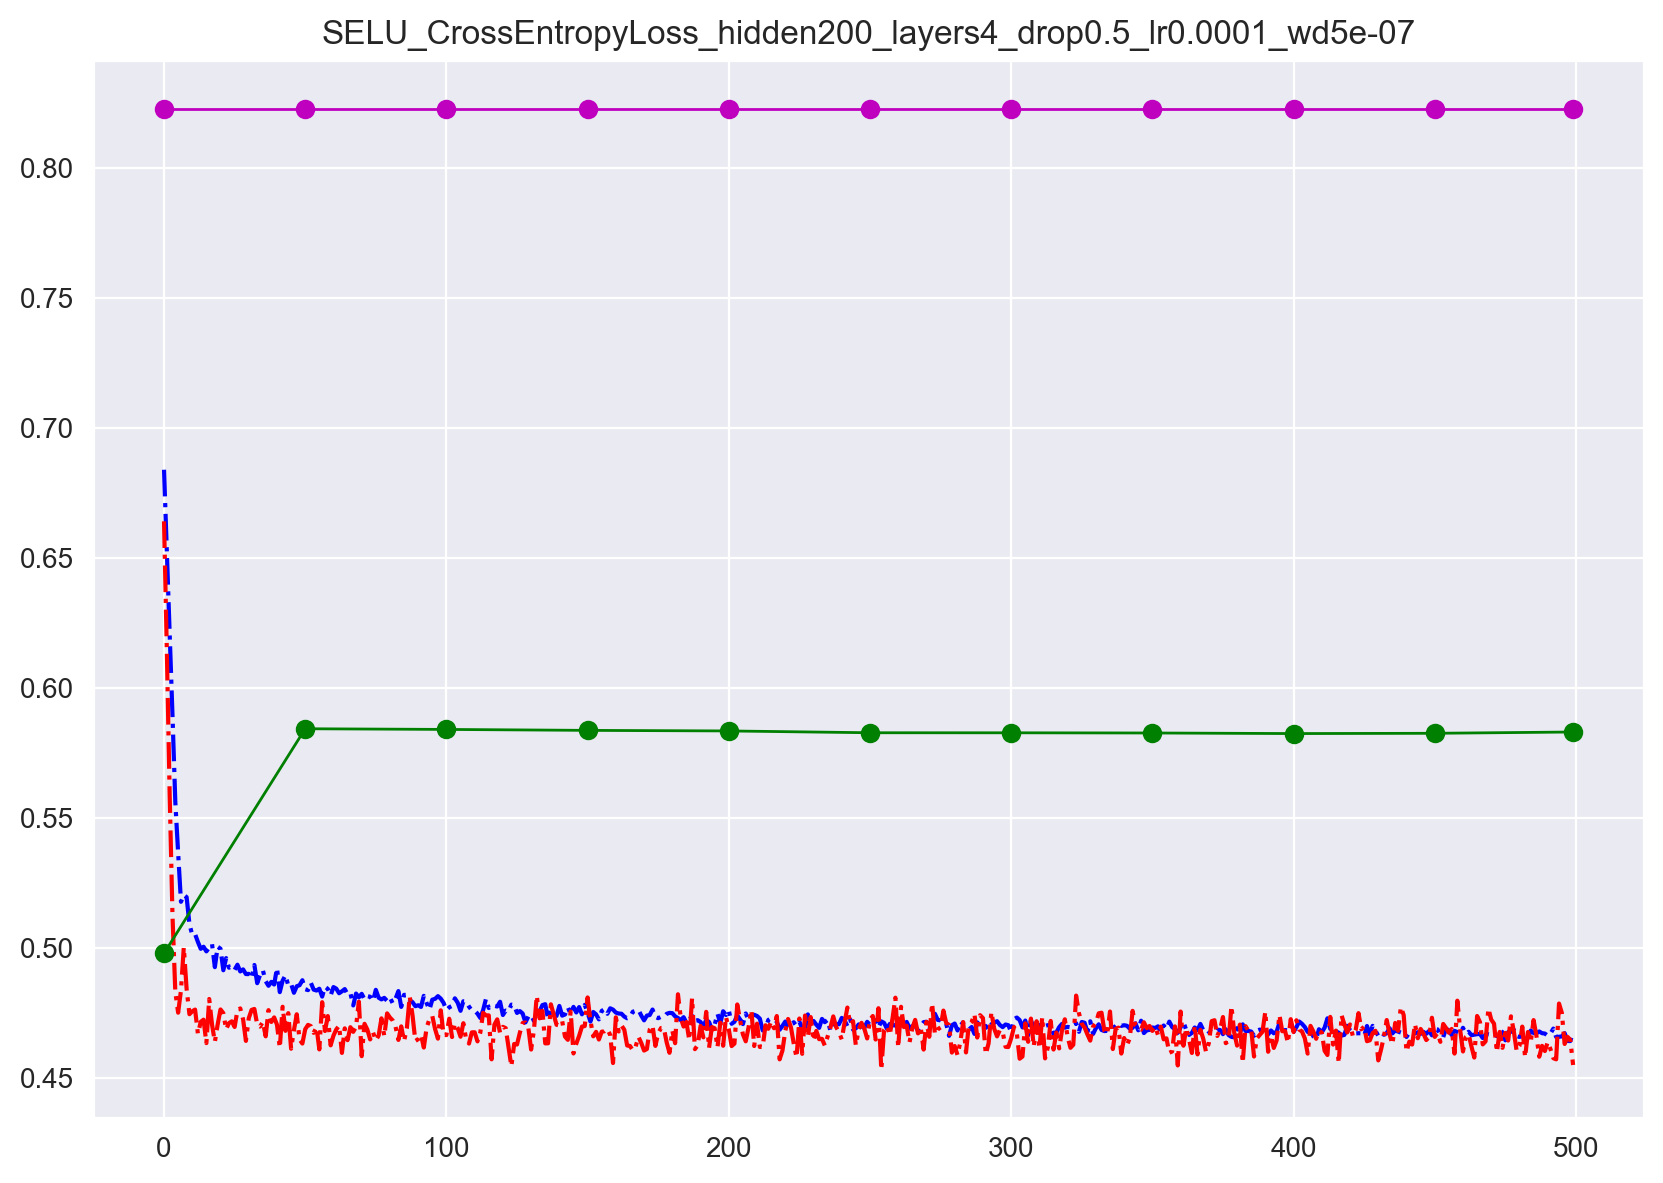

In [269]:
x = np.arange(0, nb_epochs, 50 )
x = np.append(x, nb_epochs-1)

for k1 in df_mlp1.sort_values('best_roc', ascending = False)['name'].values[0:3]:
    plt.figure(figsize=(10,7))
    k = list(ls[k1].keys())
    plt.plot(ls[k1][k[0]], 'b-.' ,label = k[0])
    plt.plot(ls[k1][k[1]], 'r-.' ,label = k[1])
    
    plt.plot(x, ls[k1][k[2]], c='g', ls = '-', lw = 1, marker = 'o' ,label = k[2])
    plt.plot(x, ls[k1][k[3]], c='m', ls = '-', lw = 1, marker = 'o' ,label = k[3])
    
    plt.title(k1)
    

In [270]:
df_mlp1.sort_values('best_roc', ascending = False).head()


,name,best_roc,roc_epoch,best_val,val_epoch
711,Sigmoid_CrossEntropyLoss_hidden150_layers4_dro...,0.585112,200,0.454898,92
837,SELU_CrossEntropyLoss_hidden250_layers4_drop0....,0.585039,499,0.452211,291
767,SELU_CrossEntropyLoss_hidden200_layers4_drop0....,0.584233,50,0.453140,254
694,SELU_CrossEntropyLoss_hidden150_layers4_drop0....,0.584002,150,0.451485,475
805,Sigmoid_CrossEntropyLoss_hidden250_layers2_dro...,0.583712,499,0.453978,123


### 1D CNN

In [177]:
class OD_CNN(nn.Module):
    
    def __init__(self, n_kernels, act = nn.SELU(), p_drop = .3, final=nn.ReLU()):
        super(OD_CNN, self).__init__()
        self.n_kernels = n_kernels
        if p_drop != 0:
            self.drop = nn.Dropout(p_drop)
        else:
            self.drop = nn.Identity()
        
        self.conv1 = nn.Conv1d(1, n_kernels, kernel_size = 51)
        self.maxpool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_kernels, n_kernels*2, kernel_size = 22)
        
        self.fc1 = nn.Linear(n_kernels*4, n_kernels*2)
        self.bn1 = nn.BatchNorm1d(n_kernels*2)
        self.fc2 = nn.Linear(n_kernels*2, n_kernels)
        self.bn2 = nn.BatchNorm1d(n_kernels)
        self.fc3 = nn.Linear(n_kernels, 64)
        self.output = nn.Linear(64, 2)
        self.act = act
        self.final = final
        
    def forward(self, x): 
        # 1D-conv layers
        x = self.act(self.maxpool(self.conv1(x.unsqueeze(1))))
        x = self.act(self.maxpool(self.conv2(x)))
        # Flattening & FC layers
        x = x.view(-1, 4*self.n_kernels)
        x = self.bn1(self.drop(self.act(self.fc1(x))))
        x = self.bn2(self.drop(self.act(self.fc2(x))))
        x = self.act(self.fc3(x))
        x = self.final(self.output(x))
        return x 

In [ ]:
torch.manual_seed(20)
cnn_losses = {}
for epi in tqdm(top5_nn.antigen_epitope.unique()):
    X_train, X_val, y_train, y_val = ovr_xy_split_class(top5_nn, epi, train_size = .667)
    cb = len(top5_nn.query('antigen_epitope==@epi'))/len(top5_nn)
    print(f'FOR CURRENT EPITOPE : {epi}, % of positive class = {cb:.2%}')
    cnn = OD_CNN(128, act = nn.ReLU(), p_drop=.25, final = nn.ReLU())
    cnn.to(device);
    
    losses = train_clf(model = cnn, data = (X_train,X_val,y_train, y_val), 
                       lr = 6.67e-5, wd = 1e-3, nb_epochs = 750, 
                       batch_size = 2**10, loss_weight = None)
    cnn_losses[epi] = losses

In [273]:
class MLP2(nn.Module):
    def __init__(self, n_layers, n_hidden, n_output, 
                 activation = nn.SELU(), p_drop = 0.5): # dropout = True):
        super(MLP2, self).__init__()
        if p_drop >0 :
            self.drop = nn.Dropout(p_drop)
        else: 
            self.drop = nn.Identity()
            
        self.input_layers = nn.Sequential(nn.Linear(100, 75),
                                          activation,
                                          nn.BatchNorm1d(75),
                                          self.drop,
                                          nn.Linear(75,50),
                                          activation,
                                          nn.BatchNorm1d(50),
                                          self.drop,
                                          nn.Linear(50, 25),
                                          activation,
                                          nn.BatchNorm1d(25),
                                          self.drop)
        # 100 -> 75
        # 75 -> 50 
        # 50 -> 25
        layers = [nn.Linear(25,n_hidden),
                  activation,]
        
        for i in range(n_layers):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(activation)
            layers.append(self.drop)
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(n_hidden, n_output)
        
    
    def forward(self, x):
        x = self.input_layers(x)
        x = self.hidden_layers(x)
        x = self.output(x)
        #x = nn.Sigmoid(x) ?
        return x 

In [ ]:
# gridsearch CNN
nb_epochs = 500
losses = {}
epi = 'GILGFVFTL'
x_epochs = np.arange(0, nb_epochs, 50)
x_epochs = np.append(x, nb_epochs-1)
X_train, X_val, y_train, y_val = ovr_xy_split_class(top5_nn, epi, train_size = .667)
X_train.to(device)
X_val.to(device)
y_train.to(device)
y_val.to(device)

df_mlp2 = pd.DataFrame(columns = ['name','best_roc','roc_epoch','best_val','val_epoch'])
ls2 = {}
for hidden in tqdm([30,50,70],
               leave = False):
    for n_layers in tqdm([1,2,3],
                        leave=False):
        for act in tqdm([nn.SELU(), nn.ReLU(), nn.Sigmoid(), nn.Tanh()], 
                      leave = False):
            for p_drop in tqdm([0, 0.5], 
                              leave = False):
                for lr in tqdm([1e-5,3e-4], 
                              leave = False):
                    for wd in tqdm([1e-2, 5e-7],
                                  leave = False):
                            
                            name = '_'.join([act.__class__.__name__,
                                             'hidden'+str(hidden),
                                             'layers'+str(n_layers),
                                             'drop'+str(p_drop),
                                             'lr'+str(lr),
                                             'wd'+str(wd)])
                            
                            mlp = MLP2(n_layers, hidden, 2, act, p_drop)
                            print(f'FOR {name}')
                            mlp.to(device)
                            losses = train_clf(model = mlp, data = (X_train,X_val,y_train, y_val), 
                                               lr = lr, wd = wd, nb_epochs = nb_epochs,
                                               batch_size = 2**12, loss_weight = None)
                            ls2[name]= losses
                            roc_epoch, best_roc = get_max(losses['roc'], x_epochs)
                            val_epoch, best_val = get_min(losses['val'], range(nb_epochs))
                            df_mlp2 = df_mlp2.append(pd.DataFrame(data=[[name, best_roc, roc_epoch, best_val, val_epoch]],
                                                        columns = ['name','best_roc','roc_epoch','best_val','val_epoch']),
                                           ignore_index=True)
                            
df_mlp2.sort_values('best_roc', ascending=False)

In [289]:
display(df_mlp1.sort_values('best_roc', ascending=False).head(10))
display(df_mlp2.sort_values('best_roc', ascending=False).head(10))


,name,best_roc,roc_epoch,best_val,val_epoch
711,Sigmoid_CrossEntropyLoss_hidden150_layers4_dro...,0.585112,200,0.454898,92
837,SELU_CrossEntropyLoss_hidden250_layers4_drop0....,0.585039,499,0.452211,291
767,SELU_CrossEntropyLoss_hidden200_layers4_drop0....,0.584233,50,0.453140,254
694,SELU_CrossEntropyLoss_hidden150_layers4_drop0....,0.584002,150,0.451485,475
805,Sigmoid_CrossEntropyLoss_hidden250_layers2_dro...,0.583712,499,0.453978,123
839,SELU_CrossEntropyLoss_hidden250_layers4_drop0....,0.583615,100,0.454754,328
855,Sigmoid_CrossEntropyLoss_hidden250_layers4_dro...,0.583258,200,0.454960,295
911,SELU_CrossEntropyLoss_hidden300_layers4_drop0....,0.583008,350,0.453107,215
908,SELU_CrossEntropyLoss_hidden300_layers4_drop0....,0.582773,499,0.450533,427
766,SELU_CrossEntropyLoss_hidden200_layers4_drop0....,0.582593,200,0.450272,44


,name,best_roc,roc_epoch,best_val,val_epoch
199,SELU_hidden70_layers1_drop0.5_lr0.0003_wd5e-07,0.585116,50,0.436353,363
126,Tanh_hidden50_layers1_drop0.5_lr0.0003_wd0.01,0.584513,150,0.435244,65
223,Tanh_hidden70_layers1_drop0.5_lr0.0003_wd5e-07,0.584371,150,0.438791,374
7,SELU_hidden30_layers1_drop0.5_lr0.0003_wd5e-07,0.584196,50,0.435268,43
222,Tanh_hidden70_layers1_drop0.5_lr0.0003_wd0.01,0.583457,100,0.434754,113
31,Tanh_hidden30_layers1_drop0.5_lr0.0003_wd5e-07,0.583434,350,0.437403,212
102,SELU_hidden50_layers1_drop0.5_lr0.0003_wd0.01,0.582934,300,0.435788,190
30,Tanh_hidden30_layers1_drop0.5_lr0.0003_wd0.01,0.582373,300,0.437751,190
198,SELU_hidden70_layers1_drop0.5_lr0.0003_wd0.01,0.582216,400,0.435094,300
103,SELU_hidden50_layers1_drop0.5_lr0.0003_wd5e-07,0.581550,350,0.435225,337


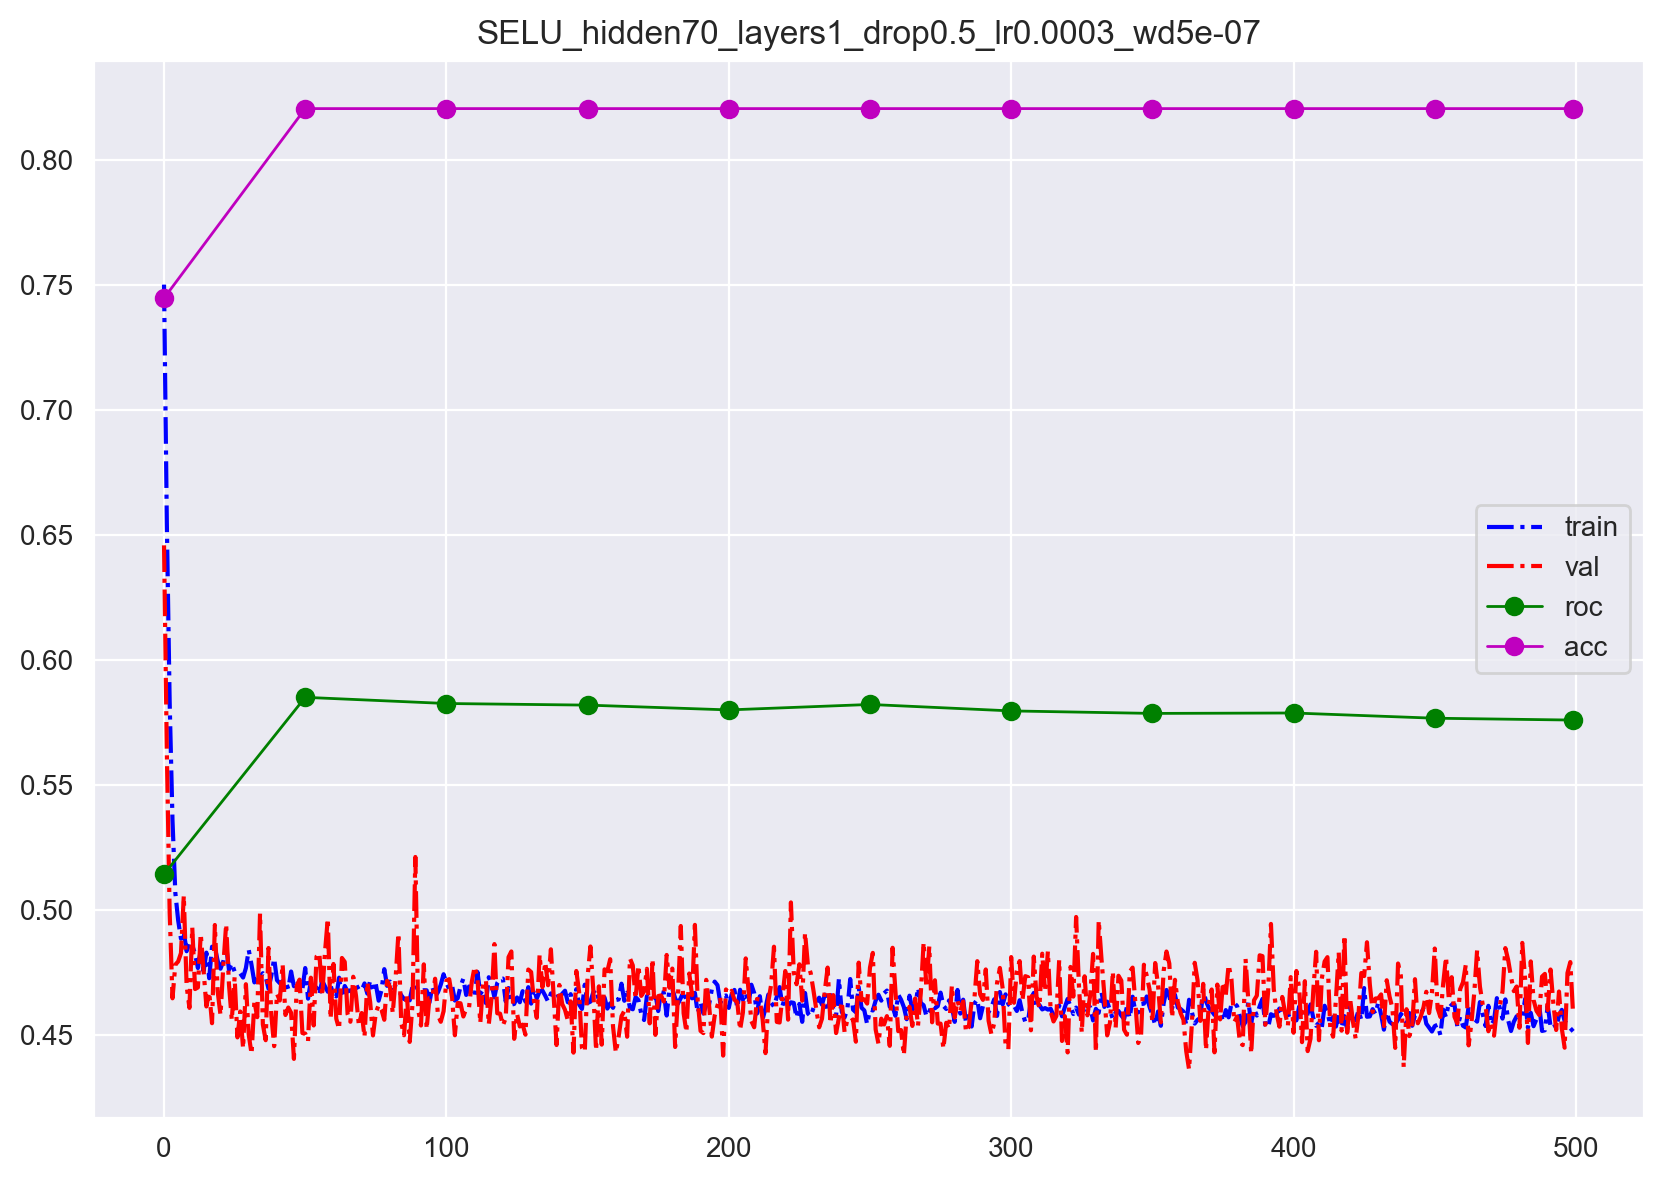

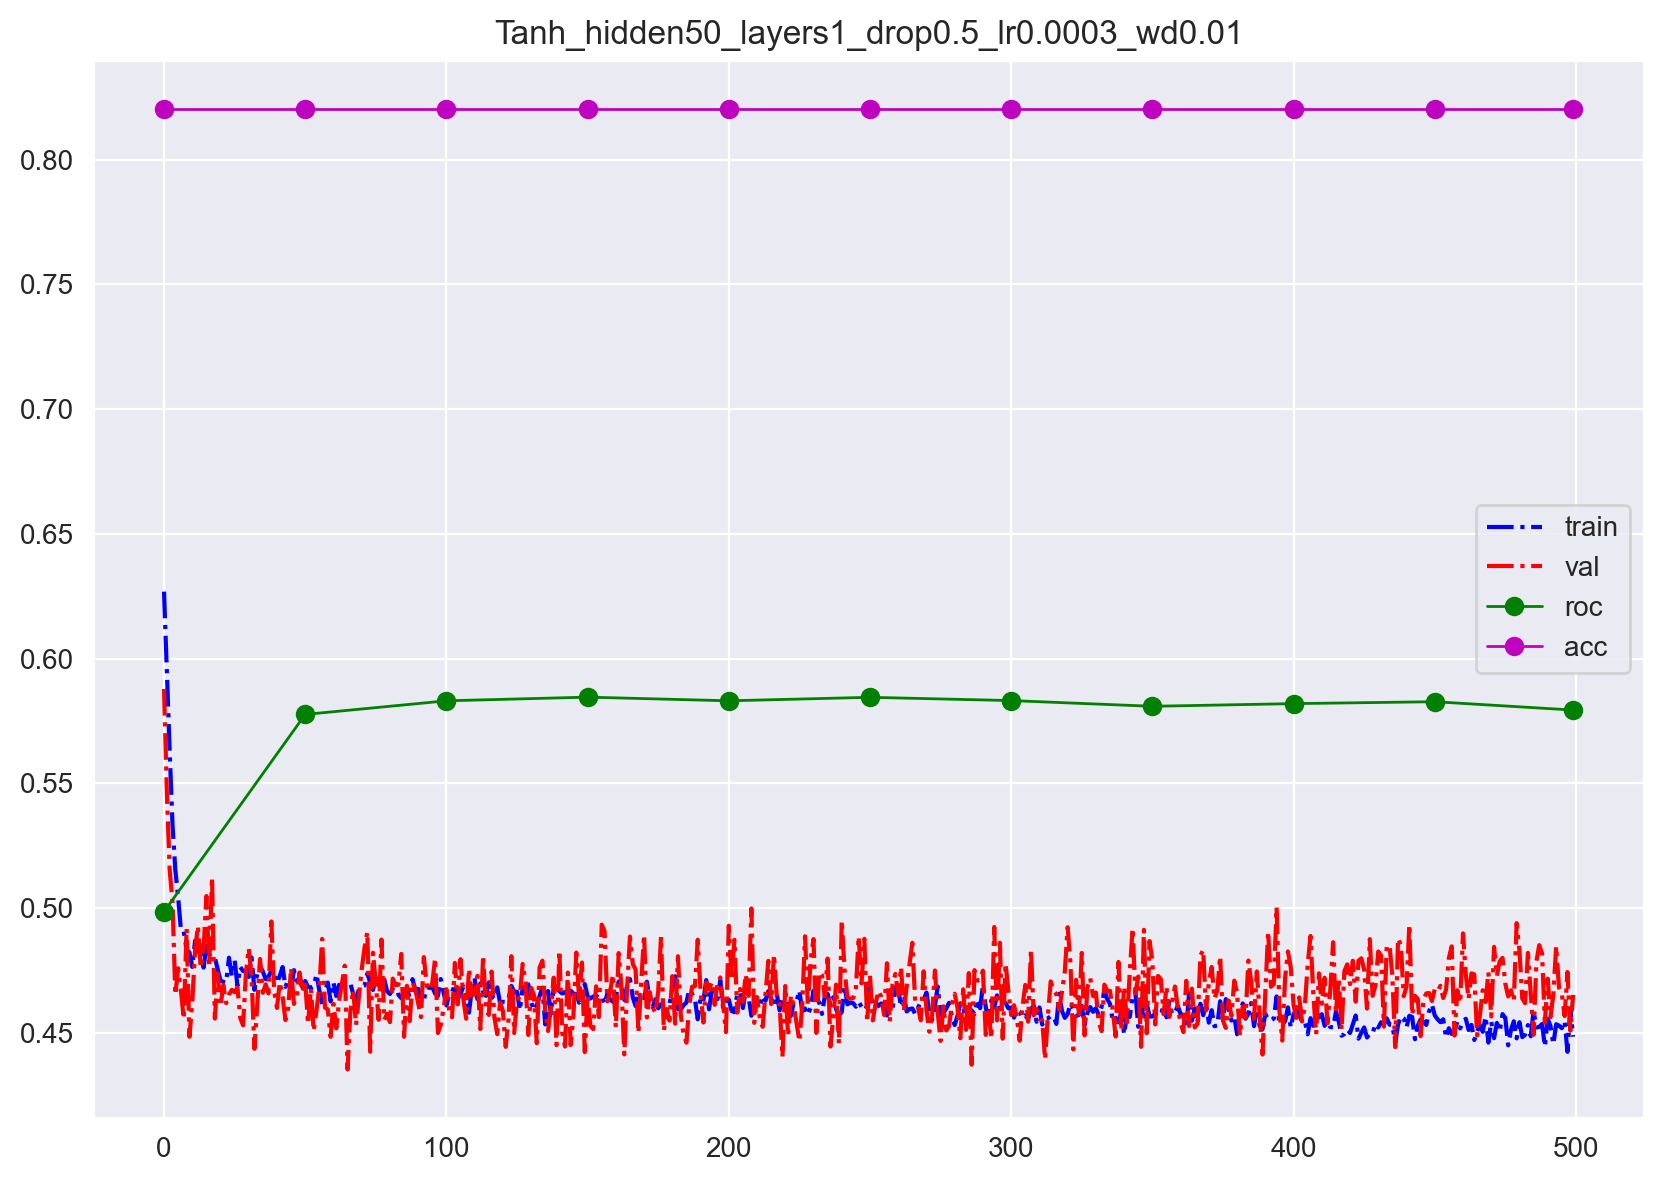

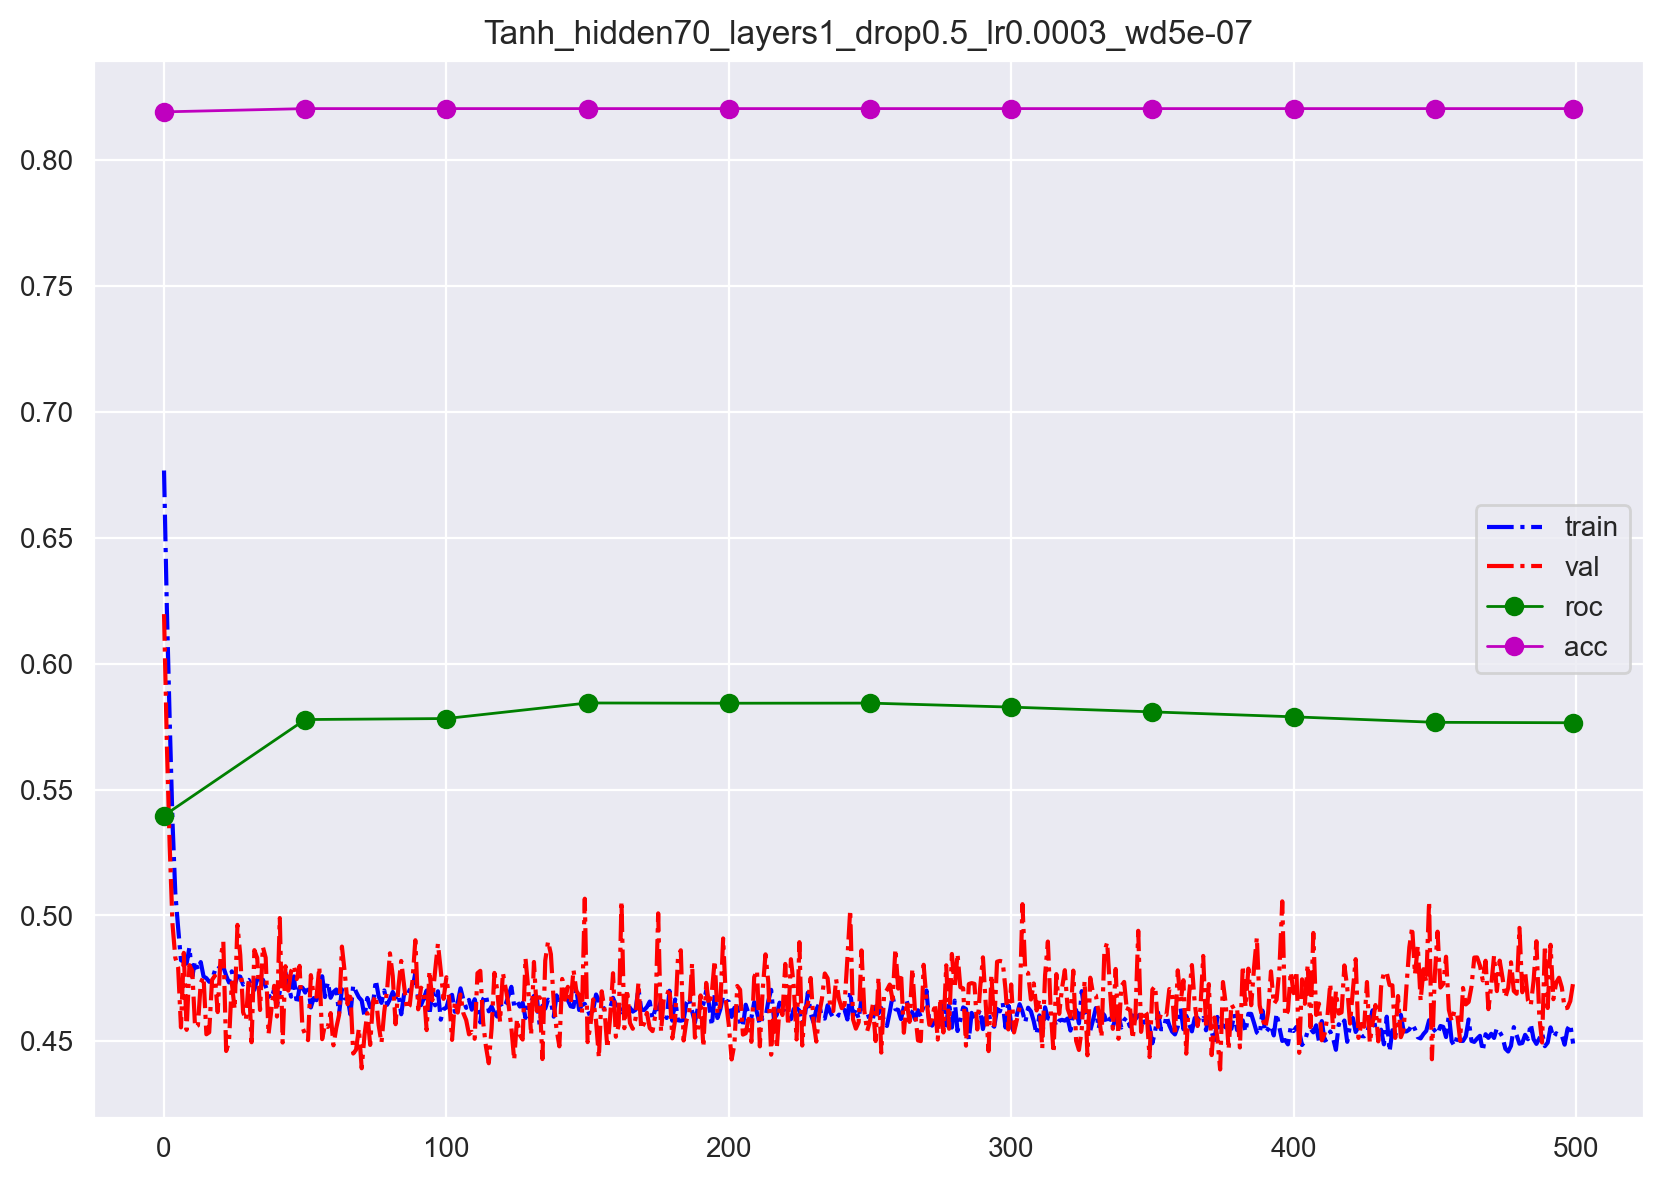

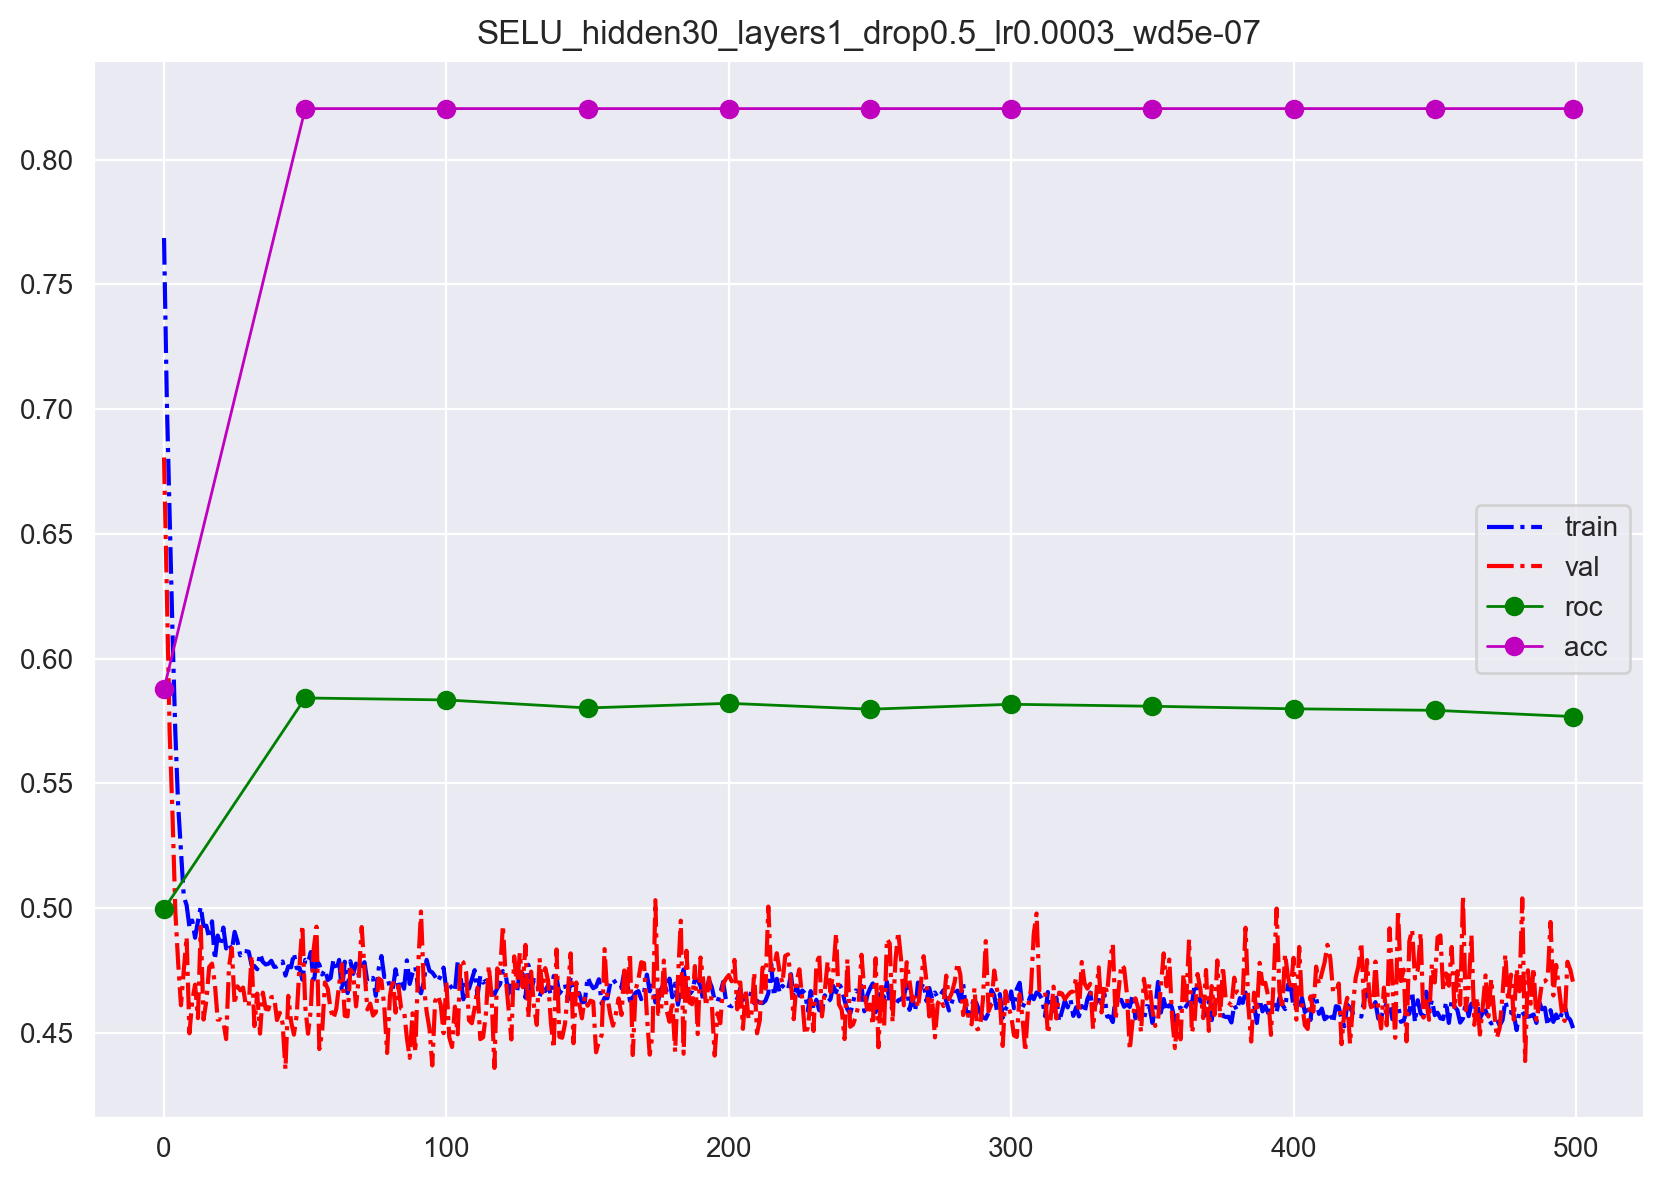

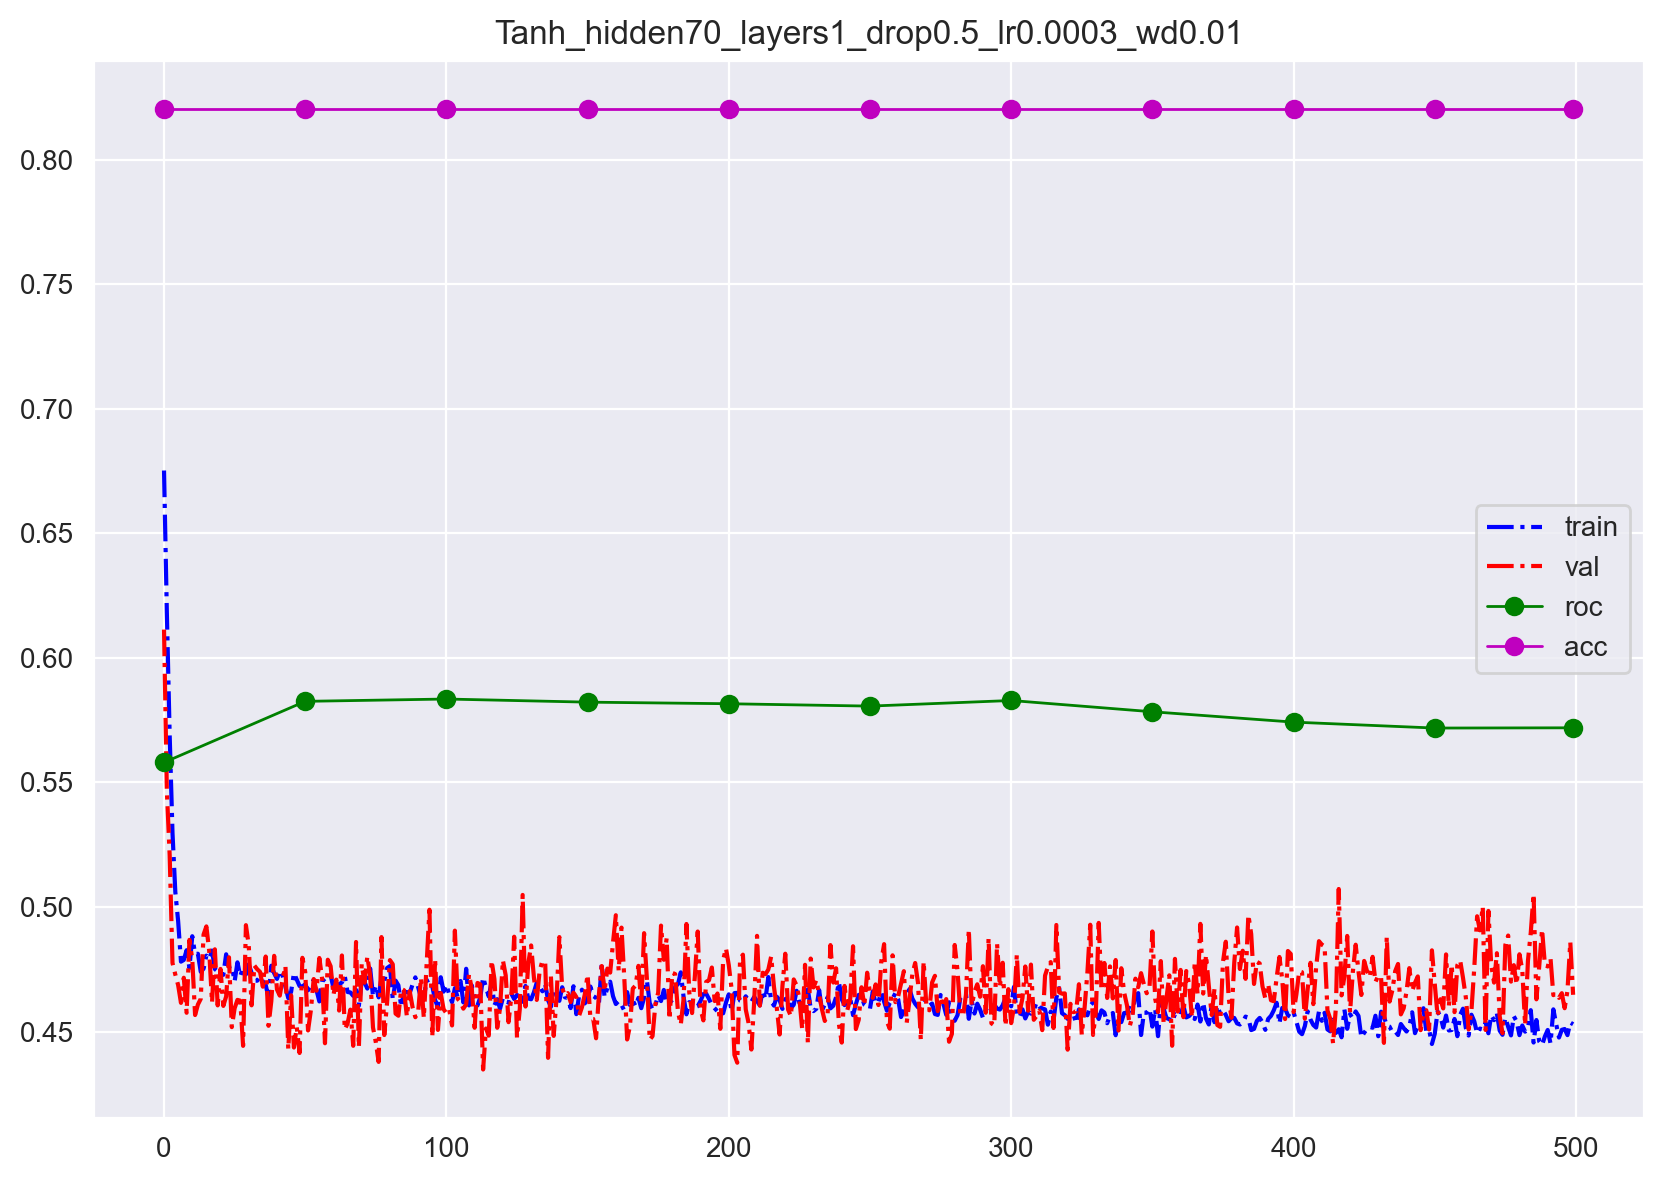

In [278]:
x = np.arange(0, nb_epochs, 50 )
x = np.append(x, nb_epochs-1)

for k1 in df_mlp2.sort_values('best_roc', ascending=False).head()['name'].values:
    plt.figure(figsize=(10,7))
    k = list(ls2[k1].keys())
    plt.plot(ls2[k1][k[0]], 'b-.' ,label = k[0])
    plt.plot(ls2[k1][k[1]], 'r-.' ,label = k[1])
    
    plt.plot(x, ls2[k1][k[2]], c='g', ls = '-', lw = 1, marker = 'o' ,label = k[2])
    plt.plot(x, ls2[k1][k[3]], c='m', ls = '-', lw = 1, marker = 'o' ,label = k[3])
    plt.legend()
    plt.title(k1)
    